In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sipm.sipm as sipm
import sipm.dataset as ds
from sipm.sipm import gauss, compound_poisson
from scipy.optimize import curve_fit
from scipy.special import erf, gamma
from scipy.signal import butter, lfilter
from scipy.signal import find_peaks
import ROOT

Welcome to JupyROOT 6.26/06


In [2]:
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def line(x,a,b):
    return a*x+b

def line_vbd(x,a,vbd):
    return a*(x-vbd)

In [4]:
!pwd

/home/as111/sipm-analysis


## Example waveforms

[12.565760127583909, 12.114750631698772, 26.792117773284097, 41.60499949172768, 16.834810826003444]


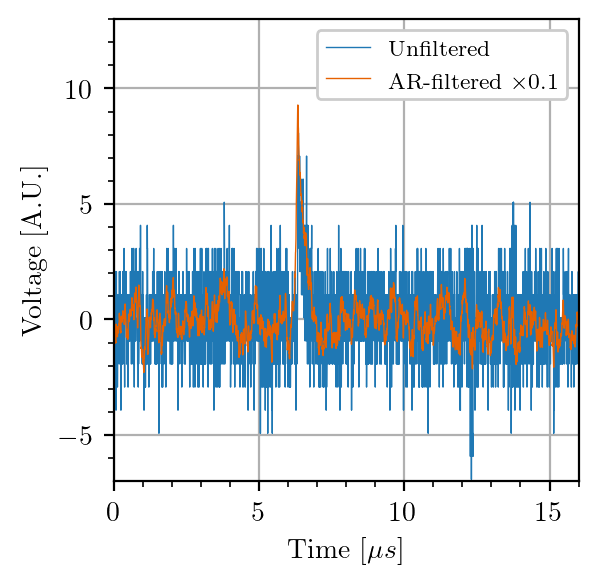

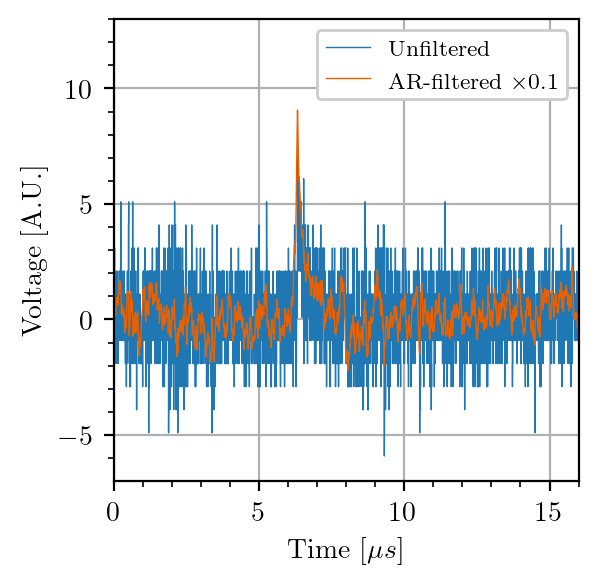

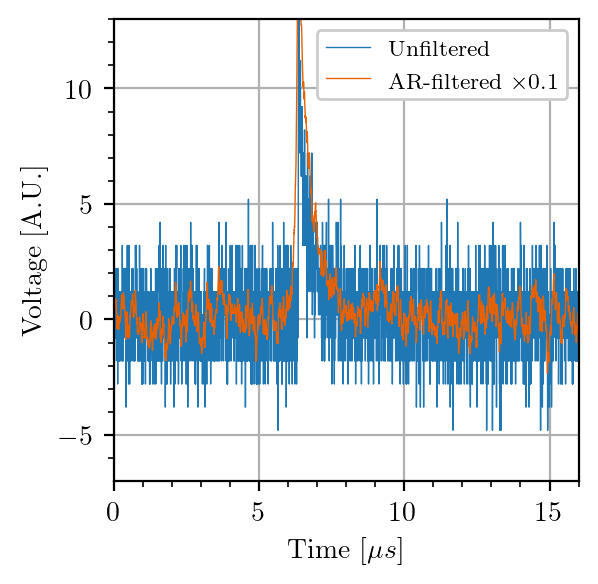

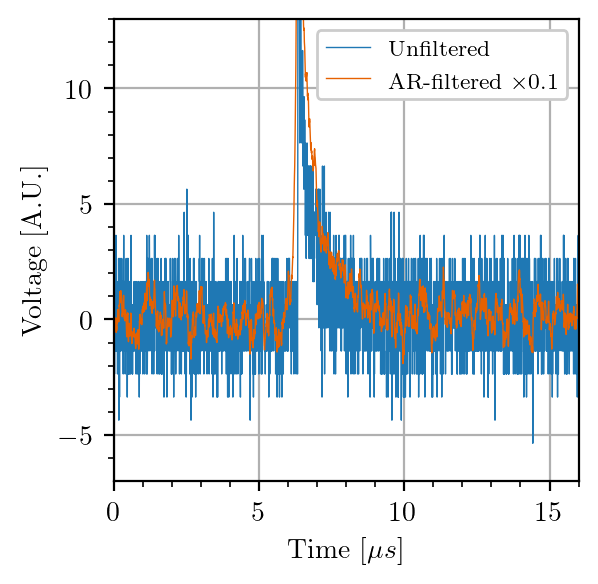

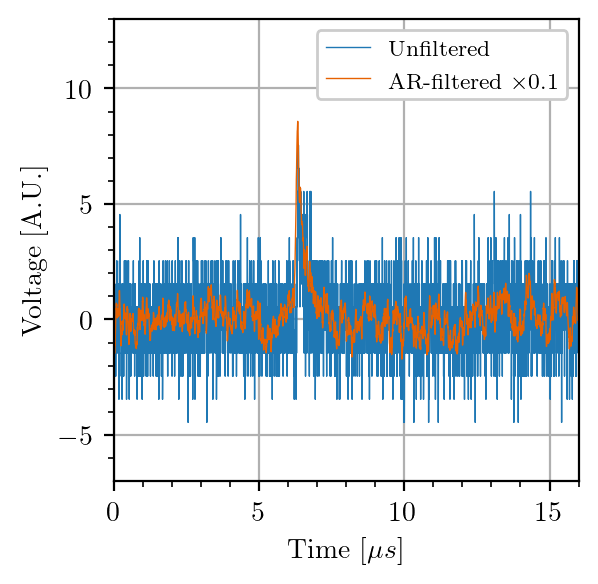

In [5]:
data_dir = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/'
direc = '2022-11-22/2022-11-22_volt_65_pos_top_light_laser_coinc_laser_cond_calibration/0/'
ch = 0
wfid = np.arange(5,10)
dset = ds.Dataset(path='{}{}'.format(data_dir,direc), mode='', pol=-1, channels=range(4))
wfs, arwfs = dset.ch[ch].get_waveforms(event_id=wfid, ar_filter=True, header=True)
snr = [np.max(w[1500:1700])/np.std(w[:1000]) for w in arwfs]
print(snr)

for i,wf in enumerate(wfs):
    plt.figure(i,figsize=(3,3))
    plt.plot(dset.ch[ch].time, wf, label='Unfiltered', linewidth=0.5)
    plt.plot(dset.ch[ch].time, arwfs[i]*0.1, label=r'AR-filtered $\times0.1$', linewidth=0.5)
    # plt.plot([1500*dset.ch[ch].sample_step]*2, [-5,15],'k--', linewidth=0.5)
    # plt.plot([1700*dset.ch[ch].sample_step]*2, [-5,15],'k--', linewidth=0.5)
    plt.legend(loc='upper right')
    plt.xlabel(r'Time [$\mu s$]')
    plt.ylabel(r'Voltage [A.U.]')
    plt.minorticks_on()
    plt.grid()
    plt.xlim(0,16)
    plt.ylim(-7,13)


# Top tile calibration (1122 data)

## Load data

In [6]:
bias = [63, 65, 67, 69, 71]
ds1122top = []
for i,volt in enumerate(bias):
    dset = ds.Dataset(path='', mode='', channels=range(4))
    file = ROOT.TFile("root/calibration_1122_{}V_top.root".format(volt), "read")
    tree = file.Get("tree")
    nev = 0
    nev_cut = [0,0,0,0]
    for iev,ev in enumerate(tree):
        nev += 1
        for ich,ch in enumerate(dset.ch):
            ch.baseline_avg.append(ev.bsl_avg[ich])
            # ch.baseline_med.append(ev.bsl_med[ich])
            ch.baseline_std.append(ev.bsl_std[ich])
            # ch.acquisition_max.append(ev.acq_max[ich])
            # ch.acquisition_min.append(ev.acq_min[ich])
            if(ev.bsl_std[ich]<2.5):
                ch.famp.append(ev.fil_amp[ich])
                ch.integral_long.append(ev.int_long[ich])
                nev_cut[ich] += 1
    file.Close()
    print('Top {}V {} events loaded.'.format(volt, nev))
    for ich,ch in enumerate(dset.ch):
        ch.cumulative_nevents = nev
        ch.nevents_aftercut = nev_cut[ich]
        print('Ch{} cut fraction={:.3f}%'.format(ich, 100*(1-nev_cut[ich]/nev)))
    ds1122top.append(dset)

Top 63V 219823 events loaded.
Ch0 cut fraction=0.044%
Ch1 cut fraction=0.061%
Ch2 cut fraction=0.047%
Ch3 cut fraction=0.034%
Top 65V 219816 events loaded.
Ch0 cut fraction=0.064%
Ch1 cut fraction=0.084%
Ch2 cut fraction=0.073%
Ch3 cut fraction=0.061%
Top 67V 219803 events loaded.
Ch0 cut fraction=0.085%
Ch1 cut fraction=0.105%
Ch2 cut fraction=0.091%
Ch3 cut fraction=0.071%
Top 69V 219813 events loaded.
Ch0 cut fraction=0.110%
Ch1 cut fraction=0.122%
Ch2 cut fraction=0.105%
Ch3 cut fraction=0.096%
Top 71V 219812 events loaded.
Ch0 cut fraction=0.133%
Ch1 cut fraction=0.137%
Ch2 cut fraction=0.121%
Ch3 cut fraction=0.115%


## Baseline cut
To avoid pre-trigger pulses or abnormal fluctuations, we require that the standard deviation in the baseline region ($t<t_{\rm trigger}-0.5~\rm\mu s$) be less than $2.5$ ADC units.
This baseline cut normalizes the baseline mean distribution.
Cut fraction is around $0.1\%$ for the top tile.
Same cut also applies to the scintillation waveforms.

Text(0, 0.5, 'Count')

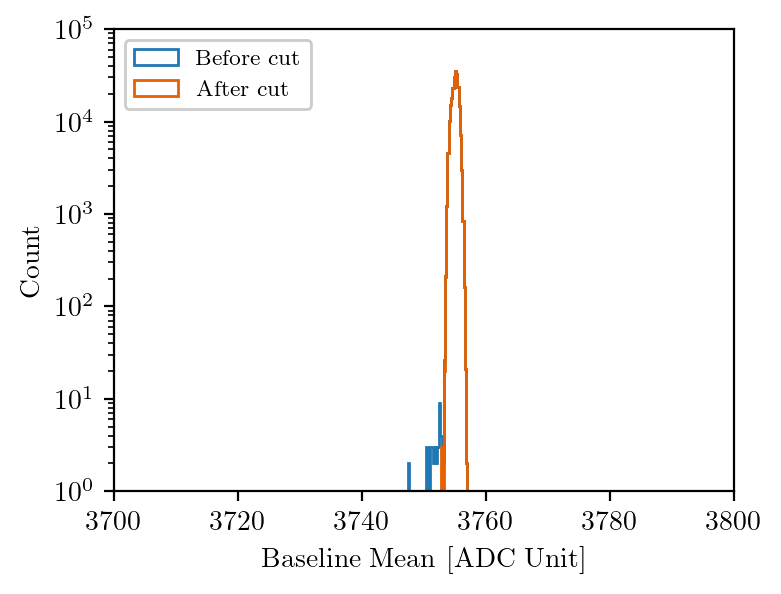

In [7]:
i=0
ch=0
dset = ds1122top[i].ch[ch]

nbins = 500
range_min = 3700
range_max = 3800
bin_width = (range_max-range_min)/nbins

bsl_avg_cut = []
for ev,avg in enumerate(dset.baseline_avg):
    if dset.baseline_std[ev]<2.5:
        bsl_avg_cut.append(avg)

plt.hist(dset.baseline_avg, label='Before cut', bins=np.linspace(range_min, range_max, nbins+1), histtype='step')
plt.hist(bsl_avg_cut, label='After cut', bins=np.linspace(range_min, range_max, nbins+1), histtype='step')
plt.legend()
plt.yscale('log')
plt.xlabel('Baseline Mean [ADC Unit]')
plt.ylabel('Count')

## Filtered amplitude and direct crosstalk (DiCT)
Here is the analysis with the prompt amplitude of AR-filtered waveforms.
The PE peak positions are identified with scipy package.
Let $A_k$ be the peak position of the $k$-PE peak (including $k=0$).
$(A_{k-1}+A_{k})/2$ is defined as the boundary between $k-1$ PEs and $k$ PEs.
The lower boundary of the 0th PE is $A_0 - 0.5(A_1-A_0)$ and similarly for the upper boundary of the highest identifiable PE.
The vertical dashed lines in the finger plots represent the boundaries.<br>

Let $P_k$ be the fraction of events within the $k$-PE boundaries, that is, the probability distribution of PE count $k$.
It can be fitted by the [compound Poisson distribution](https://ieeexplore.ieee.org/document/5402300) describing a binomial chain process (with parameter $p$ called the DiCT probability) with Poisson-distributed primary photoelectrons (with parameter $\mu$ equal to average incident photons times PDE).
The expected value is $\rm{E}[k]=\frac{\mu}{1-p}$ and the variance is $\rm{Var}[k]=\frac{\mu(1+p)}{(1-p)^2}$.


<Figure size 1800x600 with 0 Axes>

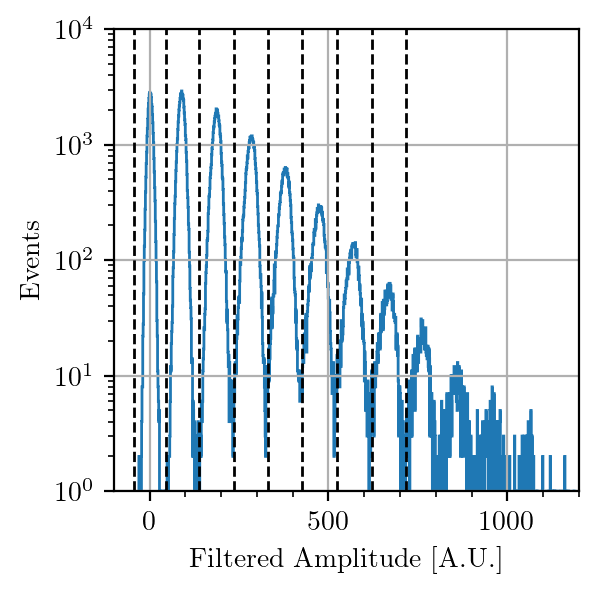

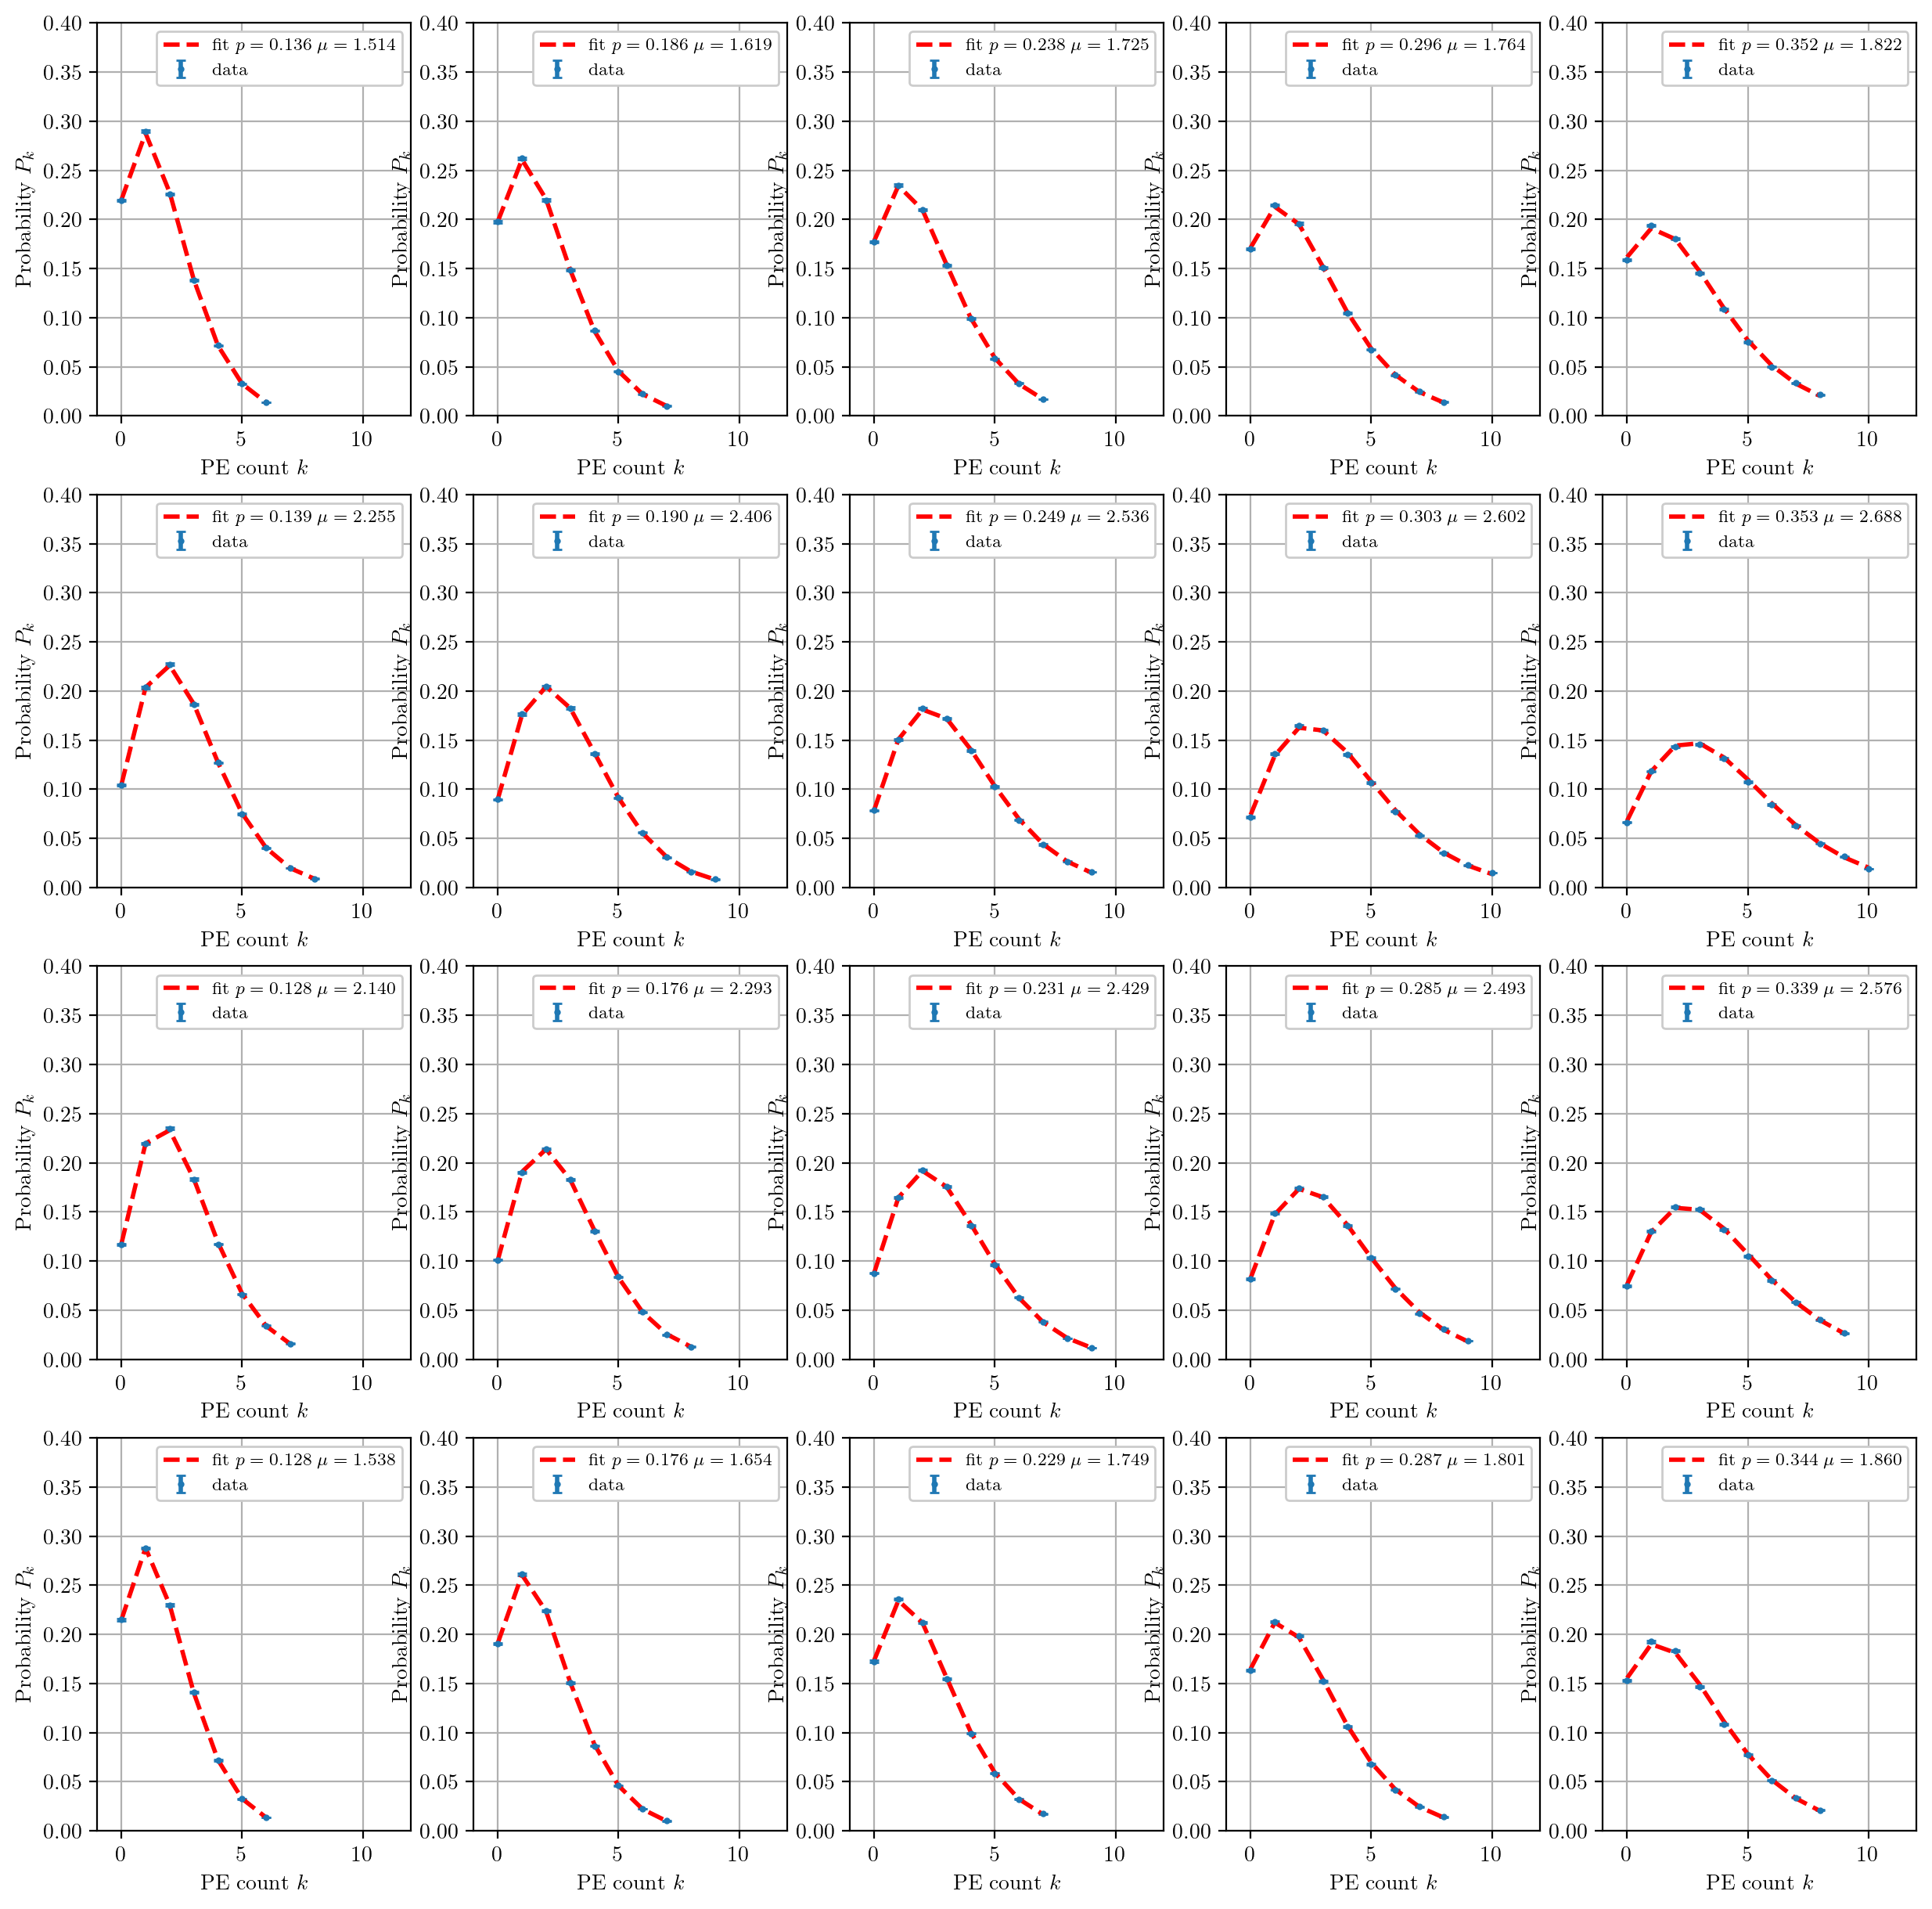

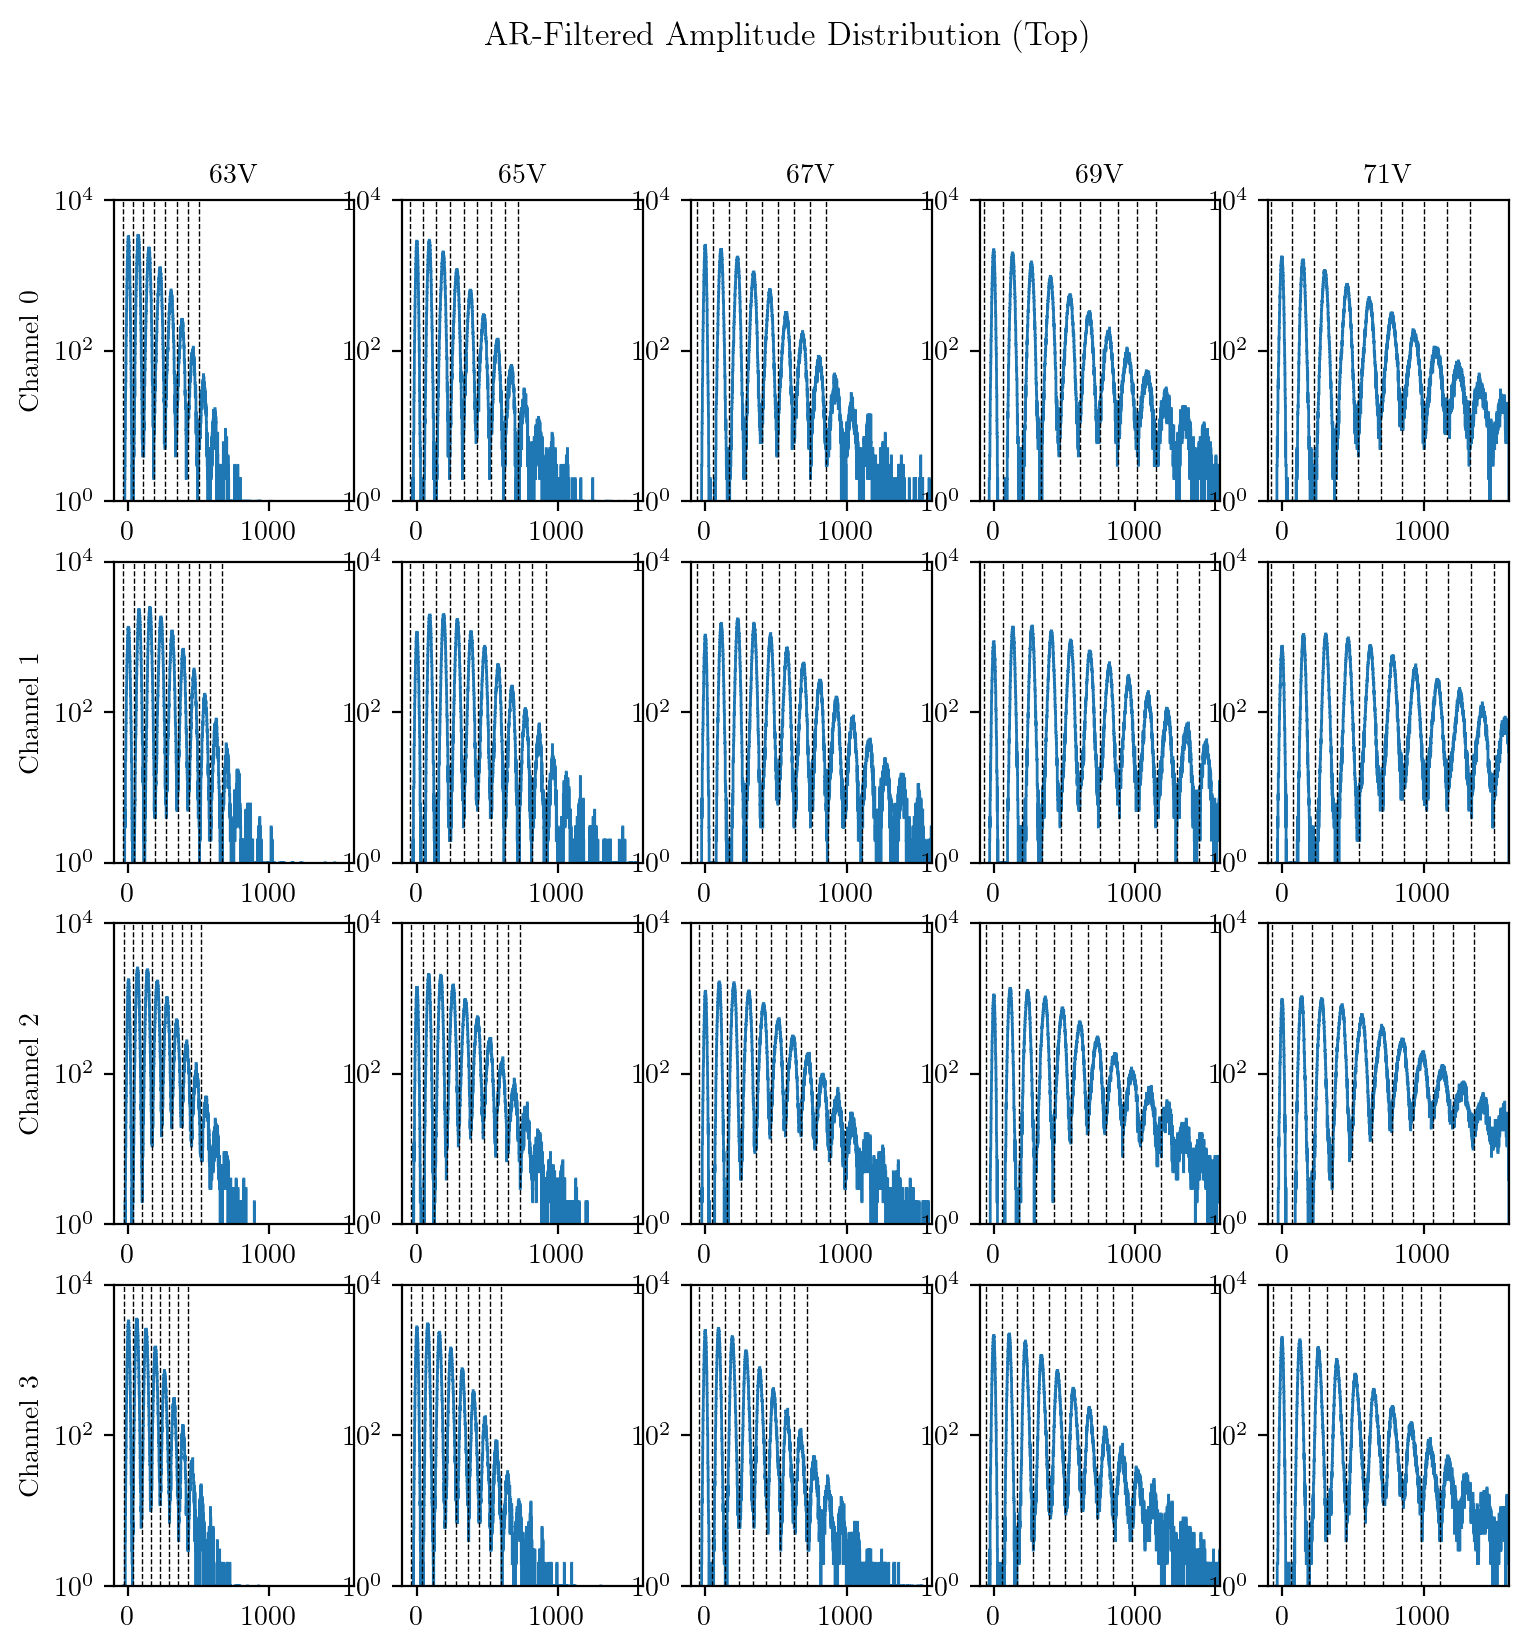

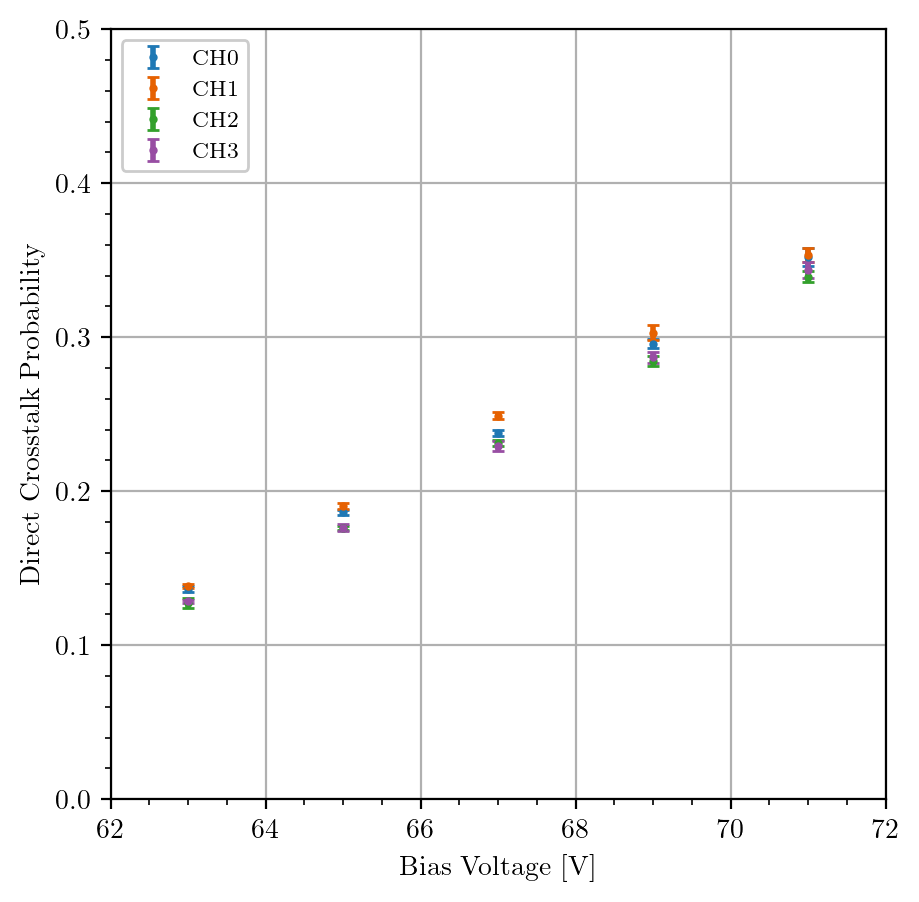

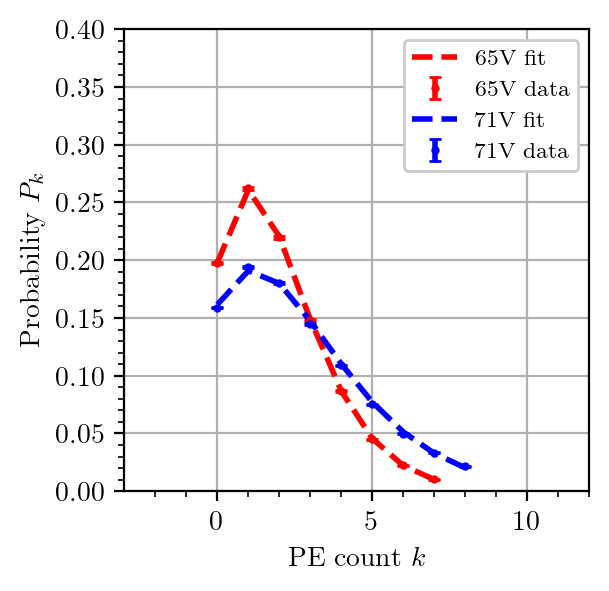

In [58]:
plt.figure(0,figsize=(9,9)) # for filtered amplitude histograms
plt.figure(1,figsize=(9,3)) # for breakdown voltage fit
plt.figure(2,figsize=(15,15)) # for Vinogradov fit
plt.figure(3,figsize=(5,5)) # for crosstalk summary
plt.figure(4,figsize=(3,3)) # finger plot for a particular channel
plt.figure(5,figsize=(3,3)) # dict fit for a particular channel
chn = 0
iv = 1
ivv = 4
Vbd_famp_top = np.zeros((4,2))
for ch in range(4):
    for i,data in enumerate(ds1122top):  
        #filtered amplitude histogram
        nbins = 1600
        range_min = -1e2
        range_max = 1.6e3
        bin_width = (range_max-range_min)/nbins
        data.ch[ch].get_famp_hist(bin=[range_min,range_max,nbins])
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.stairs(data.ch[ch].famp_hist, data.ch[ch].famp_hist_bin)
        plt.yscale('log')
        plt.xlim(data.ch[ch].famp_hist_bin[0], data.ch[ch].famp_hist_bin[-1])
        plt.ylim(1, 1e4)
        # find pe peaks in histograms
        data.ch[ch].find_histo_peaks(hist='famp', thre=0, prom=50, wid=10, dist=8)
        # fit pe peaks with Gaussian
        # min_bins, max_bins = data.ch[ch].fit_histo_peaks(hist='famp')
        # npe = len(data.ch[ch].famp_hist_fit)
        # for ipe in range(npe):
        #     popt = [data.ch[ch].famp_hist_fit[ipe][ipar][0] for ipar in range(3)]
        #     plt.plot(data.ch[ch].famp_hist_bin[min_bins[ipe]:max_bins[ipe]], gauss(data.ch[ch].famp_hist_bin[min_bins[ipe]:max_bins[ipe]], *popt), color=colors[1], lw=1, zorder=10)
        #     if ipe==0:
        #         print('A1={:.3f} sigma1={:.3f}'.format(data.ch[ch].famp_hist_fit[0][1][0], data.ch[ch].famp_hist_fit[0][2][0]))
        #fit pe-mean vs pe with linear
        # Afilt = [[data.ch[ch].famp_hist_fit[k][1][0], data.ch[ch].famp_hist_fit[k][1][1]] for k in range(npe)]
        # xlin = np.linspace(1,npe,npe)
        # ylin = np.array(Afilt)[:,0]
        # popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], sigma=np.array(Afilt)[:,1], maxfev=10000)          
        # data.ch[ch].set_spe_gain(q_a=[popt[0], np.sqrt(pcov[0,0])]) # This is Q_A
        #Vinogradov fit
        #Use Gaussian normalization
        # N_k = [data.ch[ch].famp_hist_fit[k][0] for k in range(npe)]
        #Use histogram integral
        # N_k = []
        P_k = []
        npe = len(data.ch[ch].peaks)
        pe_cuts = []
        for ipe in range(npe+1):
            # if ipe==0:
            #     min_ipe = int((0.5*data.ch[ch].famp_hist_fit[ipe][1][0]-range_min)/bin_width)
            # else:
            #     min_ipe = int((0.5*(data.ch[ch].famp_hist_fit[ipe][1][0]+data.ch[ch].famp_hist_fit[ipe-1][1][0])-range_min)/bin_width)
            # if ipe==npe-1:
            #     max_ipe = int((1.5*data.ch[ch].famp_hist_fit[ipe][1][0]-0.5*data.ch[ch].famp_hist_fit[ipe-1][1][0]-range_min)/bin_width)
            # else:
            #     max_ipe = int((0.5*(data.ch[ch].famp_hist_fit[ipe+1][1][0]+data.ch[ch].famp_hist_fit[ipe][1][0])-range_min)/bin_width)
            if ipe==0:
                pe_cuts.append(int(1.5*data.ch[ch].peaks[0]-0.5*data.ch[ch].peaks[1]))
            elif ipe==npe:
                pe_cuts.append(int(1.5*data.ch[ch].peaks[-1]-0.5*data.ch[ch].peaks[-2]))
            else:
                pe_cuts.append(int(0.5*(data.ch[ch].peaks[ipe]+data.ch[ch].peaks[ipe-1])))
            # N_k.append([np.sum(data.ch[ch].famp_hist[min_ipe:max_ipe]), np.sqrt(np.sum(data.ch[ch].famp_hist[min_ipe:max_ipe]))])
            plt.plot([pe_cuts[ipe]*bin_width+range_min, pe_cuts[ipe]*bin_width+range_min], [1,1e4], 'k--', linewidth=0.5)
            if ipe>0:
                P_k.append([np.sum(data.ch[ch].famp_hist[pe_cuts[ipe-1]:pe_cuts[ipe]])/data.ch[ch].nevents_aftercut, np.sqrt(np.sum(data.ch[ch].famp_hist[pe_cuts[ipe-1]:pe_cuts[ipe]]))/data.ch[ch].nevents_aftercut])
        # plot one particular channel
        if ch==chn and i==iv:
            plt.figure(4)
            plt.stairs(data.ch[ch].famp_hist, data.ch[ch].famp_hist_bin)
            plt.yscale('log')
            for pe_cut in pe_cuts:
                plt.plot([pe_cut*bin_width+range_min, pe_cut*bin_width+range_min], [1,1e4], 'k--', linewidth=1)
            plt.xlabel('Filtered Amplitude [A.U.]')
            plt.ylabel('Events')
            # plt.suptitle('Top Ch{} {}V'.format(ch, bias[i]))
            plt.xlim(data.ch[ch].famp_hist_bin[0], 1200)
            plt.ylim(1, 1e4)
            plt.minorticks_on()
            plt.grid()

        plt.figure(2)
        plt.subplot(4,5,ch*5+i+1)
        # plt.errorbar(np.arange(1,len(N_k)+1), np.array(N_k)[:,0], yerr=np.array(N_k)[:,1], fmt='o', markersize=2, label='data')
        plt.errorbar(np.arange(len(P_k)), np.array(P_k)[:,0], yerr=np.array(P_k)[:,1], fmt='o', markersize=2, label='data')
        popt,pcov = curve_fit(compound_poisson, list(np.arange(len(P_k))), np.array(P_k)[:,0], p0=[2, 0.2], sigma=np.array(P_k)[:,1], maxfev=10000)
        # print('mu={:.3f} p={:.3f}'.format(popt[1], popt[2]))
        data.ch[ch].set_correlated_noise(ct=[popt[1],np.sqrt(pcov[1,1])])
        plt.plot(np.arange(len(P_k)), compound_poisson(np.arange(len(P_k)),*popt), 'r--', label=r'fit $p={:.3f}$ $\mu={:.3f}$'.format(popt[1],popt[0]))
        plt.ylim(0,0.4)
        plt.xlim(-1,12)
        plt.xlabel(r'PE count $k$')
        plt.ylabel(r'Probability $P_k$')
        plt.legend(loc='upper right')
        plt.grid()
        if ch==chn and (i==iv or i==ivv):
            plt.figure(5)
            if i==iv:
                color='r'
            else:
                color='b'
            plt.errorbar(np.arange(len(P_k)), np.array(P_k)[:,0], yerr=np.array(P_k)[:,1], fmt='{}o'.format(color), markersize=2, label='{}V data'.format(bias[i]))
            plt.plot(np.arange(len(P_k)), compound_poisson(np.arange(len(P_k)),*popt), '{}--'.format(color), label='{}V fit'.format(bias[i]))

    # plot crosstalk
    plt.figure(3)
    plt.errorbar(bias, [data.ch[ch].ct[0] for data in ds1122top], yerr=[data.ch[ch].ct[1] for data in ds1122top], label='CH{}'.format(ch), fmt='o', markersize=2)

    #breakdown voltage fit and plot
    # xlin = bias
    # ylin = [data.ch[ch].q_a[0] for data in ds1122top]
    # err = [data.ch[ch].q_a[1] for data in ds1122top]
    # popt,pcov = curve_fit(line_vbd, xlin, ylin, sigma=err, p0=[20, 55], maxfev=10000)
    # print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    # Vbd_famp_top[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    # plt.figure(1)
    # plt.subplot(1,4,ch+1)
    # plt.title('Channel {}'.format(ch))
    # plt.ylabel('Gain (A.U.)')
    # plt.xlabel('Bias (V)')
    # plt.errorbar(xlin,ylin,yerr=err,fmt='o', markersize=2)
    # plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    # plt.xlim(50,80)
    # plt.ylim(0,250)
        
plt.figure(0)
plt.suptitle('AR-Filtered Amplitude Distribution (Top)')
plt.savefig('plots/sipm/famp_histo_top_1122.pdf')
# plt.figure(1)
# plt.suptitle('Breakdown Voltage (Top)')
# plt.savefig('plots/sipm/gain_bias_famp_top_1122.pdf')
plt.figure(3)
plt.legend()
plt.xlabel('Bias Voltage [V]')
plt.ylabel('Direct Crosstalk Probability')
plt.grid()
plt.minorticks_on()
plt.xlim(62,72)
plt.ylim(0, 0.5)
plt.savefig('plots/sipm/dict_top_1122.pdf')
plt.figure(5)
plt.ylim(0,0.4)
plt.xlim(-3,12)
plt.xlabel(r'PE count $k$')
plt.ylabel(r'Probability $P_k$')
plt.minorticks_on()
plt.grid()
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [0,2,1,3]
#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='upper right')

## Afterpulsing
Here is the analysis with time integral of the unfiltered waveforms.
The integral window is $5~\rm\mu s$ post-trigger and $0.5~\rm \mu s$ pre-trigger.
The integrals are grouped by the PE counts $k$ defined with the filtered amplitude (see previous cell).
The integral distribution has a Gaussian left tail but a heavier right tail due to afterpulses.
The part of the histograms near the peak is fitted by a Gaussian PDF to find the peak position, denoted by $I_{k,\rm peak}$.
$I_{k,\rm peak}$ is linear with $k$, and the slope $Q_{\rm peak}$ is the SPE gain of the SiPMs in arbitrary units.<br>

The average of the histogram is denoted by $I_{k,\rm avg}$.
It is also linear with $k$, and the slope is denoted by $Q_{\rm avg}$.
$Q_{\rm avg}$ is essentially the afterpulse charge per PE in addition to the SPE gain $Q_{\rm peak}$.
So the average afterpulse charge per PE is defined as $Q_{\rm AP}=\frac{Q_{\rm avg}}{Q_{\rm peak}}-1$.<br>

The breakdown voltage is obtained by a linear fit to $Q_{\rm peak}$ as a function of bias $V$ using $Q_{\rm peak}=C(V-V_{\rm bd})$.
A comparison of breakdown voltage across channels is further down in the notebook.

Channel 0 Vbd=54.168+/-0.139V slope=50.446+/-0.609
Channel 1 Vbd=53.186+/-0.136V slope=46.289+/-0.487
Channel 2 Vbd=53.518+/-0.215V slope=46.551+/-0.725
Channel 3 Vbd=53.103+/-0.443V slope=44.407+/-1.268


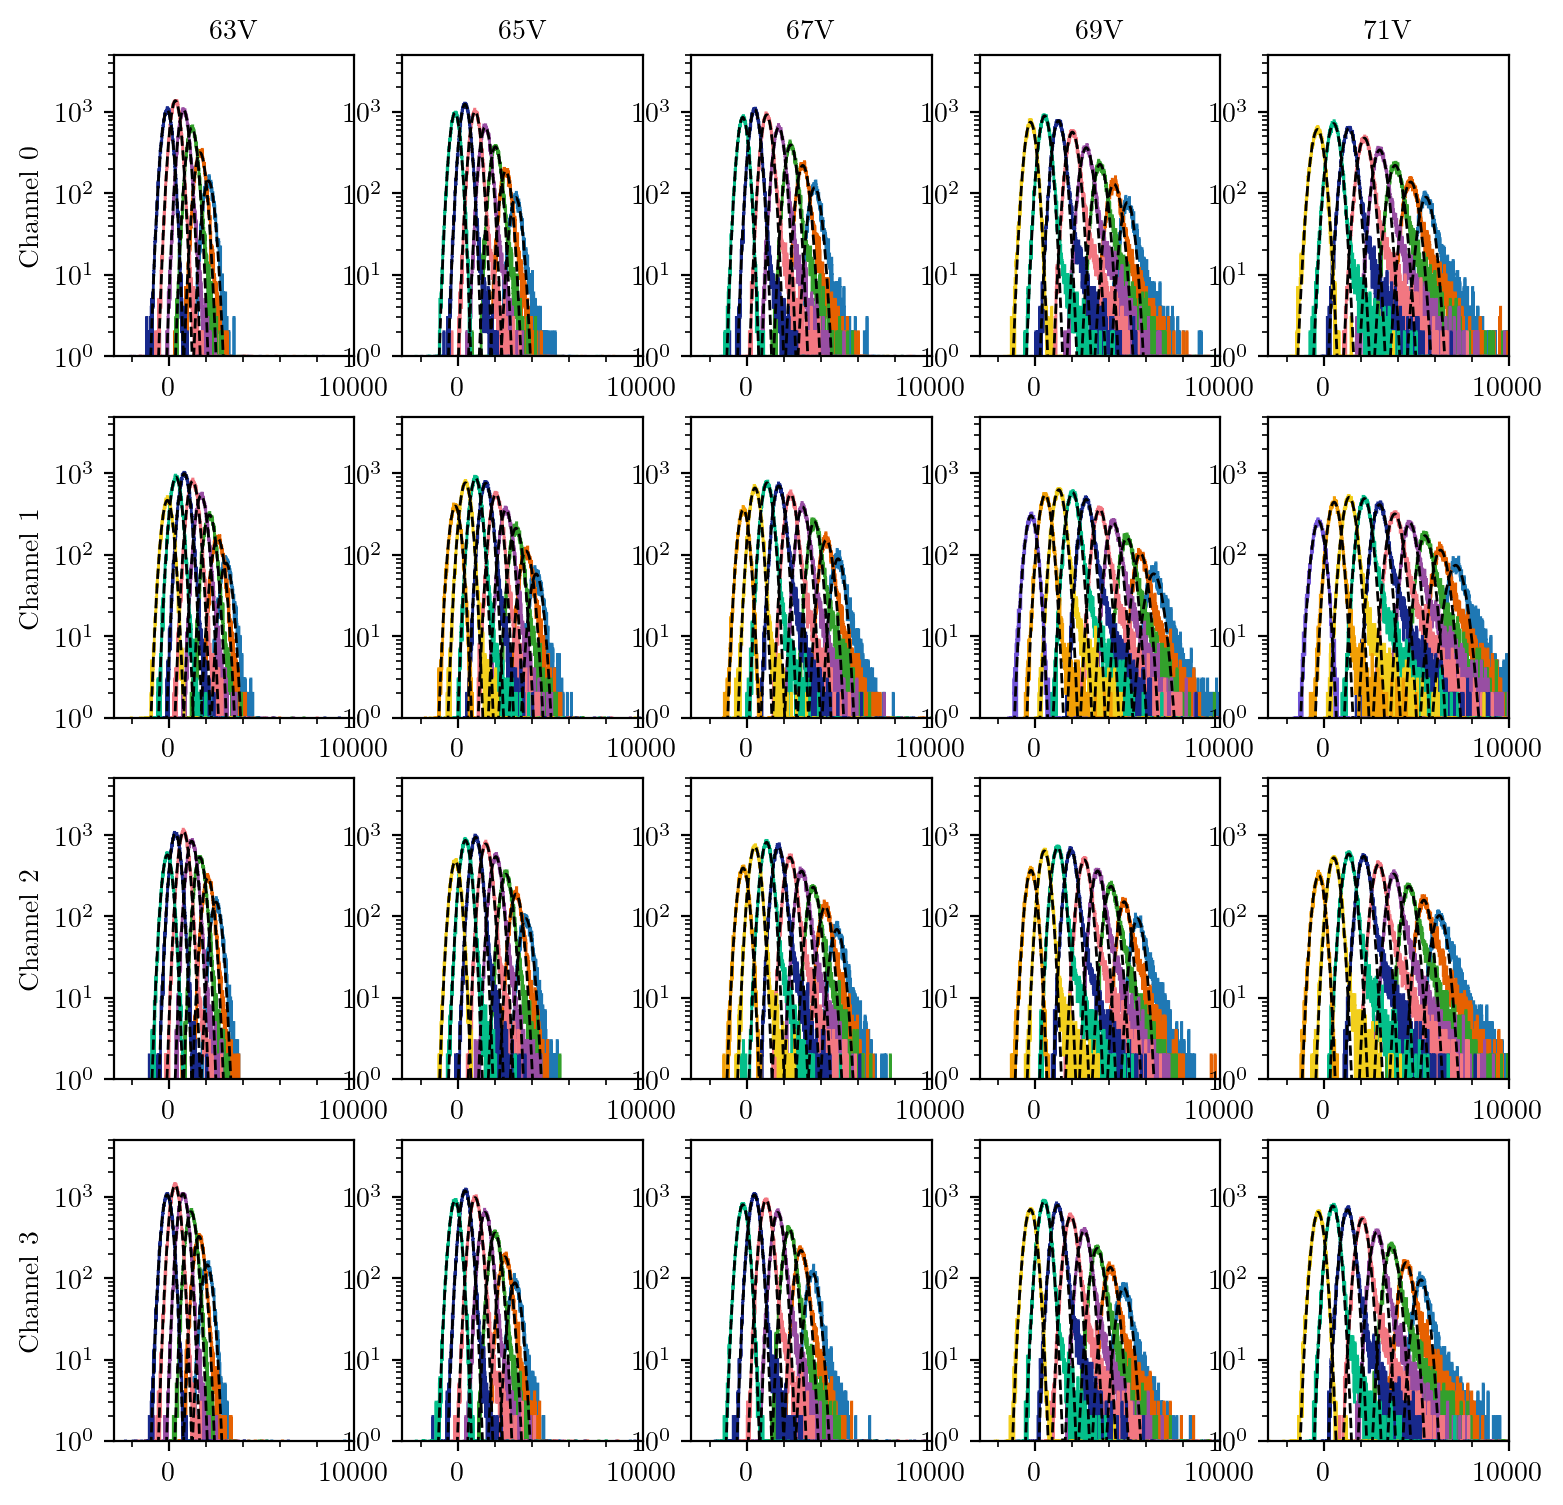

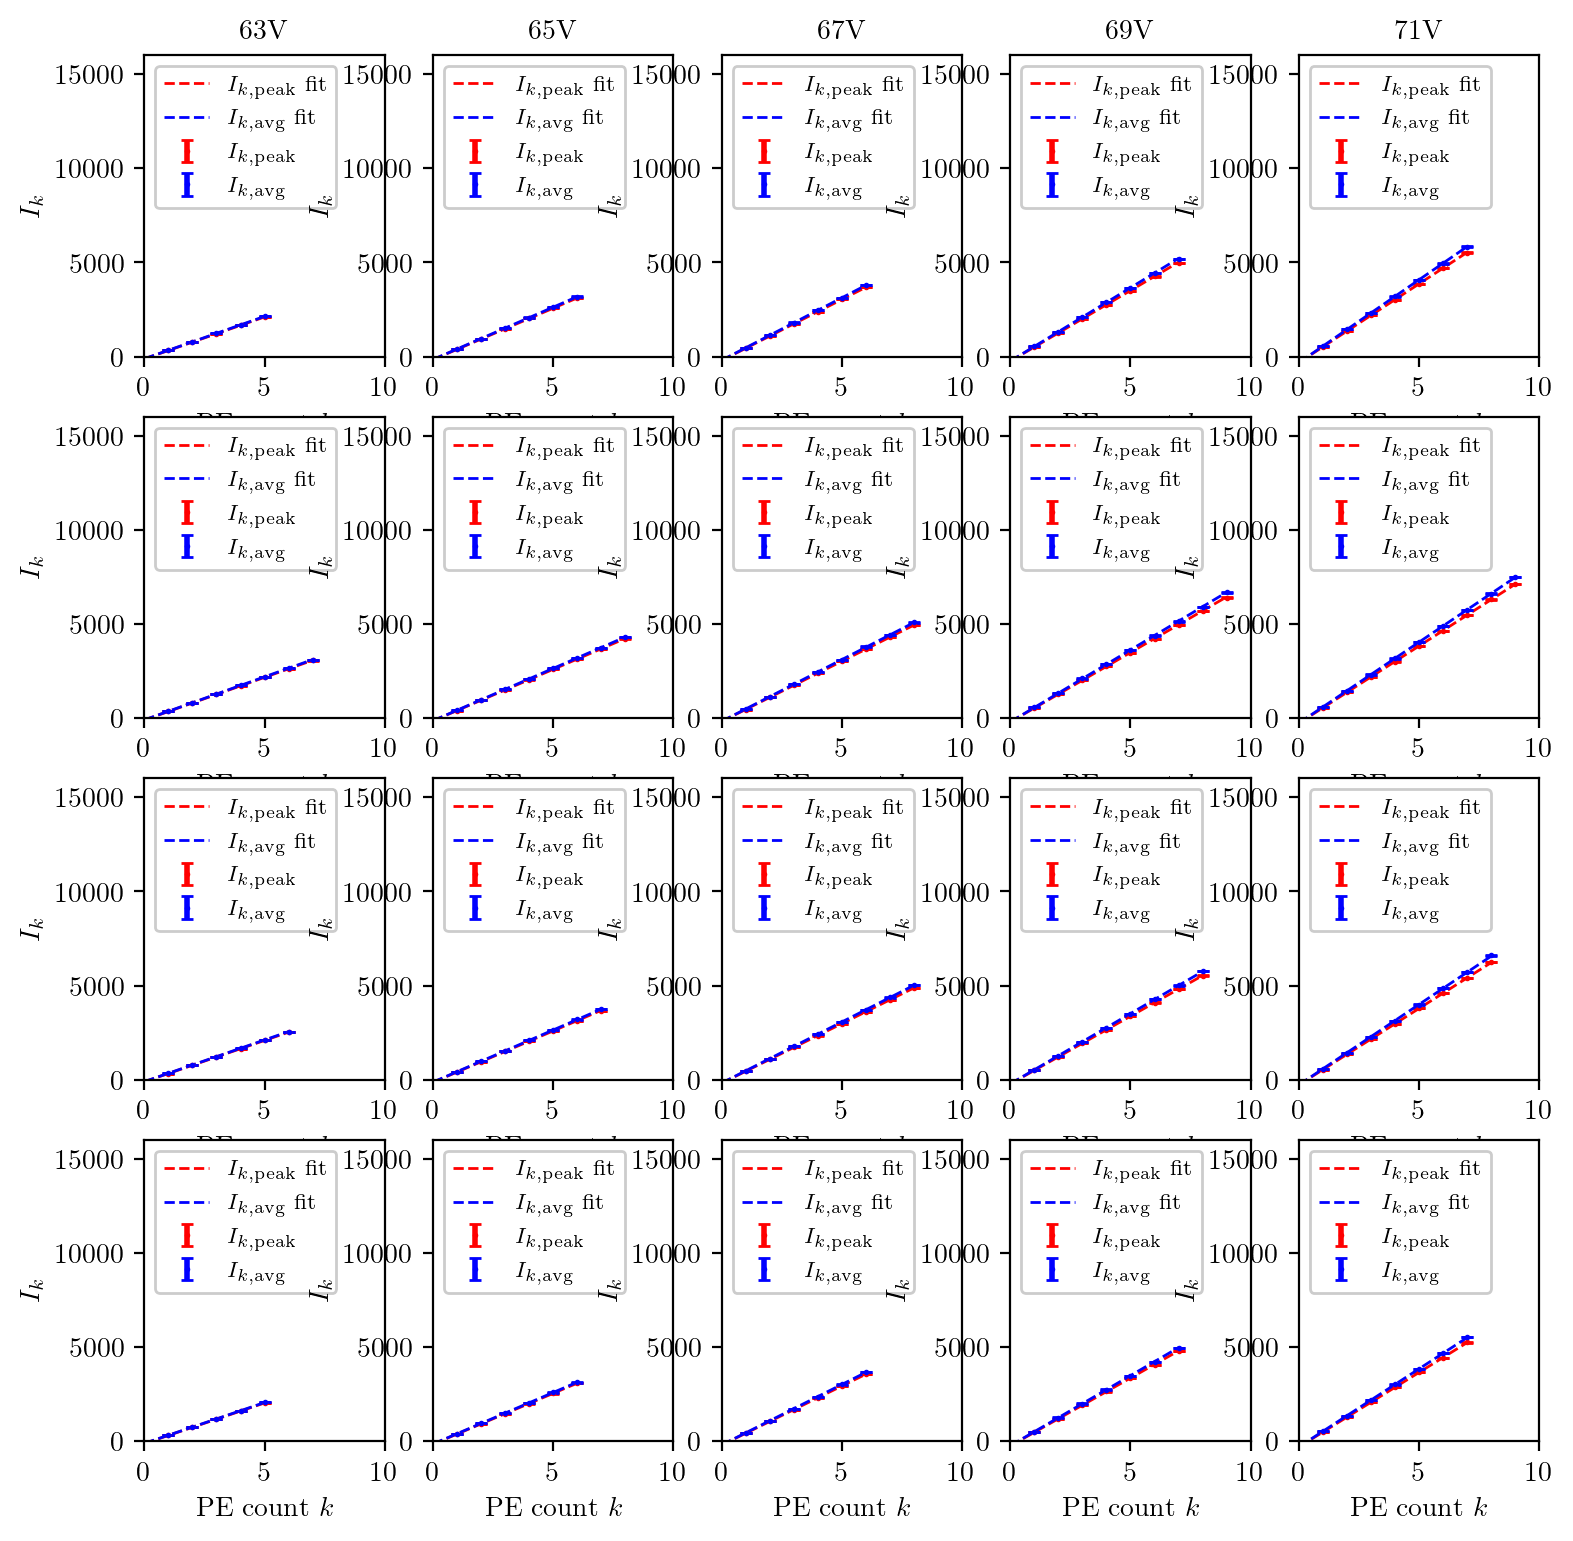

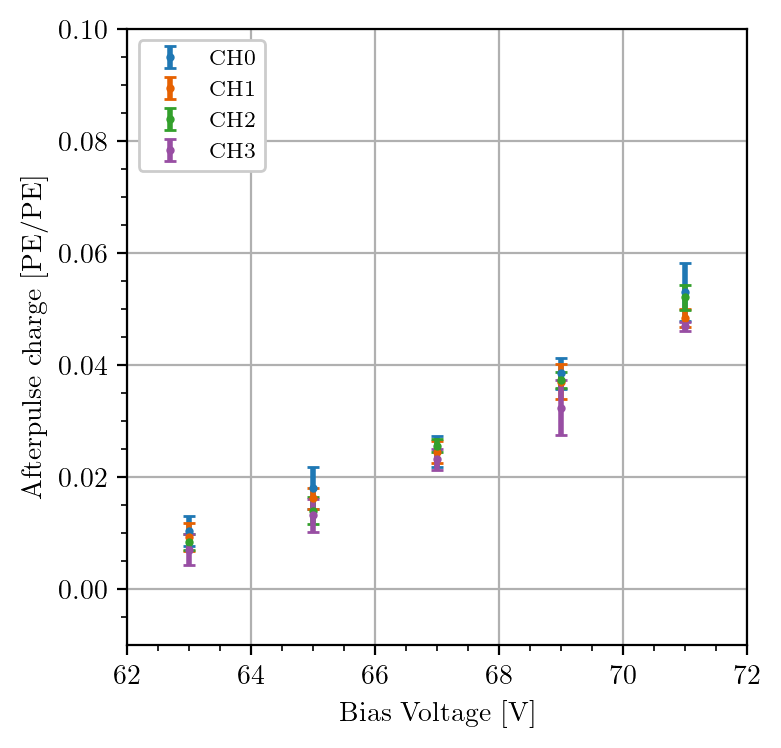

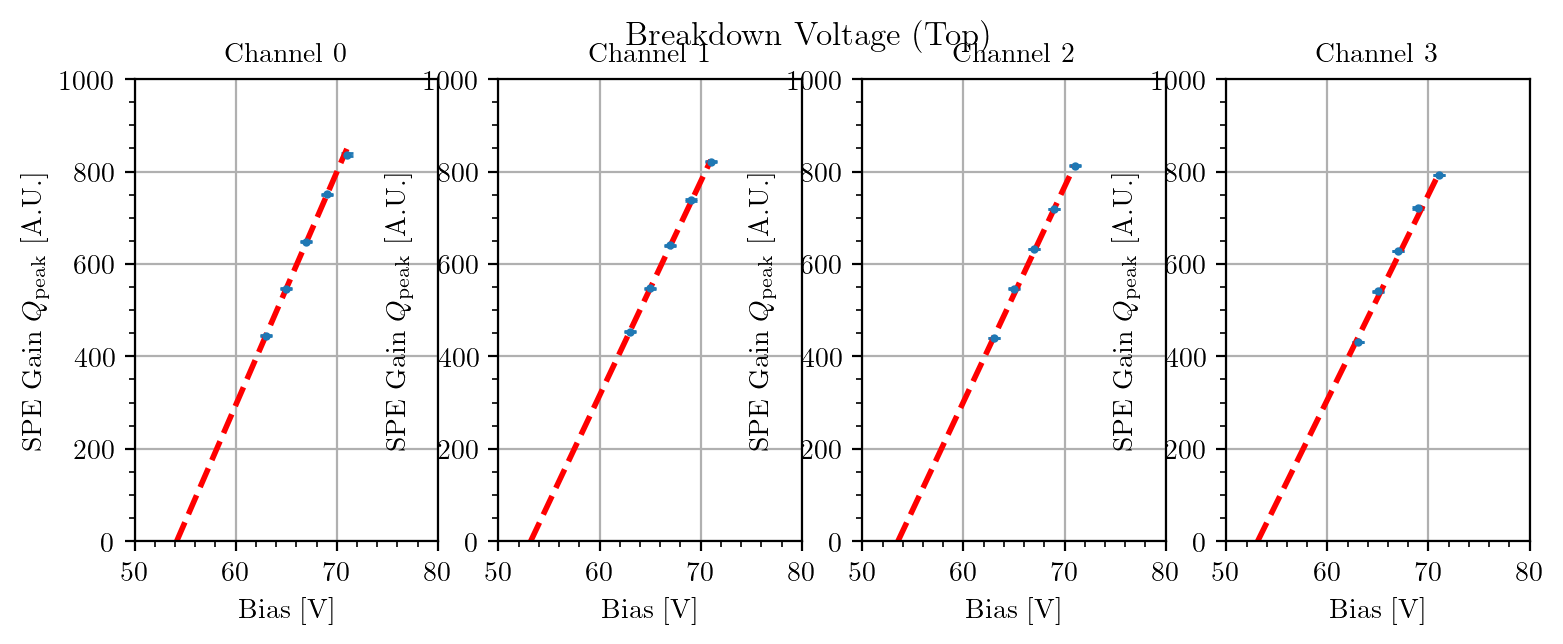

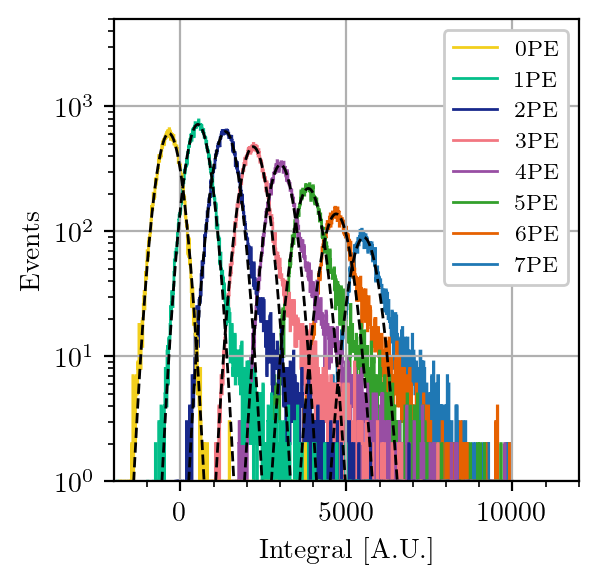

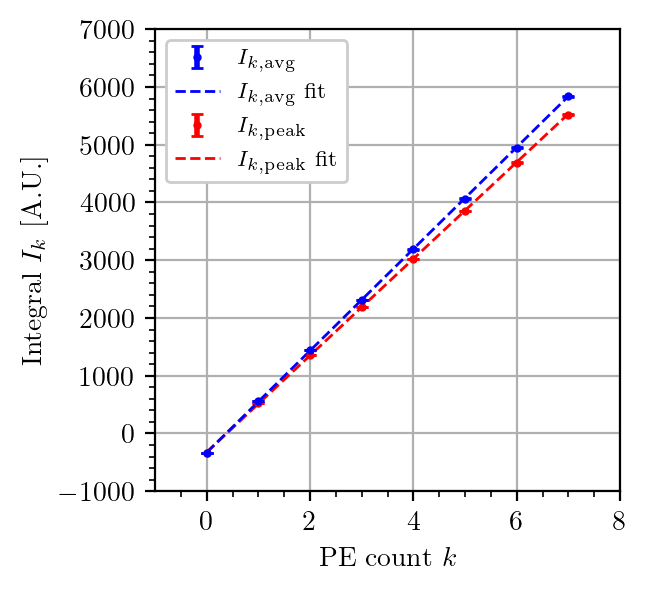

In [9]:
plt.figure(0,figsize=(9,9)) # for I_k histograms
plt.figure(1,figsize=(9,9)) # for I_k fits
plt.figure(2,figsize=(4,4)) # for afterpulse
plt.figure(3,figsize=(9,3)) # for Vbd
plt.figure(4,figsize=(3,3)) # histogram for one particular channel
plt.figure(5,figsize=(3,3)) # gain-bias fit for one particular channel
Vbd_charge_top = np.zeros((4,2))
x_min=-3000
x_max=1e4
n_bins=1000
bin_w = (x_max-x_min)/n_bins
chn = 0
iv = 4
for ch in range(4):
    for i,data in enumerate(ds1122top):
        Ik_peak = [] 
        Ik_avg = []
        data.ch[ch].get_afterpulse_charge(bin=[x_min, x_max, n_bins])
        
        #histogram and Gaussian fit
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        last_w = int(0.7*np.std(data.ch[ch].ap_charge[-1])/bin_width)
        for j in np.arange(len(data.ch[ch].ap_charge)-2,-1,-1):
            plt.stairs(data.ch[ch].ap_charge_hist[j], data.ch[ch].ap_charge_hist_bin[j])
            Ik_avg.append([np.mean(data.ch[ch].ap_charge[j]), np.std(data.ch[ch].ap_charge[j])/np.sqrt(len(data.ch[ch].ap_charge[j]))])
            w = int(0.7*np.std(data.ch[ch].ap_charge[j])/bin_width) # in bins
            p = np.argmax(data.ch[ch].ap_charge_hist[j]) # in bins
            # print('w={} last_w={}'.format(w, last_w))
            w=min(last_w,40) # something weird happened so I need to do this
            # print('ch{} {}V {}PE {}-{}'.format(ch, bias[i], j, p-w,p+w))
            last_w = w
            popt,pcov = curve_fit(gauss, data.ch[ch].ap_charge_hist_bin[j][p-w:p+w], data.ch[ch].ap_charge_hist[j][p-w:p+w], p0=[np.max(data.ch[ch].ap_charge_hist[j])*w*bin_w,p*bin_w+x_min,w*bin_w], sigma=np.sqrt(data.ch[ch].ap_charge_hist[j][p-w:p+w]), maxfev=100000)
            plt.plot(data.ch[ch].ap_charge_hist_bin[j][:-1], gauss(data.ch[ch].ap_charge_hist_bin[j][:-1], *popt), 'k--', linewidth=1)
            Ik_peak.append([popt[1],np.sqrt(pcov[1,1])])
            if ch==chn and i==iv:
                plt.figure(4)
                plt.stairs(data.ch[ch].ap_charge_hist[j], data.ch[ch].ap_charge_hist_bin[j], label='{}PE'.format(j))
                plt.plot(data.ch[ch].ap_charge_hist_bin[j][:-1], gauss(data.ch[ch].ap_charge_hist_bin[j][:-1], *popt), 'k--', linewidth=1)
                plt.legend(loc='upper right')
                plt.minorticks_on()
                plt.grid()
            plt.figure(0)

        plt.xlim(data.ch[ch].ap_charge_hist_bin[0][0], data.ch[ch].ap_charge_hist_bin[0][-1])
        plt.ylim(1,5e3)
        plt.yscale('log')
        plt.minorticks_on()
        # plt.grid()
        # plot mu-pe vs avg-pe
        Ik_peak = list(reversed(Ik_peak))
        Ik_avg = list(reversed(Ik_avg))
        plt.figure(1)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        # Q_peak fit
        plt.errorbar(np.arange(len(data.ch[ch].ap_charge)-1), np.array(Ik_peak)[:,0], yerr=np.array(Ik_peak)[:,1], fmt='r.', markersize=2, label=r'$I_{k,\rm peak}$')
        popt,pcov=curve_fit(line,np.arange(len(data.ch[ch].ap_charge)-1), np.array(Ik_peak)[:,0], p0=[500,0], sigma=np.array(Ik_peak)[:,1], maxfev=10000)
        # print('Q_peak = {:.3f}+/-{:.3f}'.format(popt[0], np.sqrt(pcov[0,0])))
        data.ch[ch].set_spe_gain(q_peak=[popt[0],np.sqrt(pcov[0,0])])
        plt.plot(np.arange(len(data.ch[ch].ap_charge)-1), line(np.arange(len(data.ch[ch].ap_charge)-1), *popt), 'r--', label=r'$I_{k,\rm peak}$ fit', linewidth=1)
        if ch==chn and i==iv:
            plt.figure(5)
            plt.errorbar(np.arange(len(data.ch[ch].ap_charge)-1), np.array(Ik_peak)[:,0], yerr=np.array(Ik_peak)[:,1], fmt='ro', markersize=2, label=r'$I_{k,\rm peak}$')
            plt.plot(np.arange(len(data.ch[ch].ap_charge)-1), line(np.arange(len(data.ch[ch].ap_charge)-1), *popt), 'r--', label=r'$I_{k,\rm peak}$ fit', linewidth=1)
        plt.figure(1)
        # Q_avg fit
        plt.errorbar(np.arange(len(data.ch[ch].ap_charge)-1), np.array(Ik_avg)[:,0], yerr=np.array(Ik_avg)[:,1], fmt='b.', markersize=2, label=r'$I_{k,\rm avg}$')
        popt_,pcov_=curve_fit(line,np.arange(len(data.ch[ch].ap_charge)-1),np.array(Ik_avg)[:,0], p0=[500,0], sigma=np.array(Ik_avg)[:,1], maxfev=10000)
        # print('Q_avg = {:.3f}+/-{:.3f}'.format(popt_[0], np.sqrt(pcov_[0,0])))
        data.ch[ch].set_spe_gain(q_avg=[popt_[0],np.sqrt(pcov_[0,0])])
        plt.plot(np.arange(len(data.ch[ch].ap_charge)-1), line(np.arange(len(data.ch[ch].ap_charge)-1), *popt_), 'b--', label=r'$I_{k,\rm avg}$ fit', linewidth=1)
        if ch==chn and i==iv:
            plt.figure(5)
            plt.errorbar(np.arange(len(data.ch[ch].ap_charge)-1), np.array(Ik_avg)[:,0], yerr=np.array(Ik_avg)[:,1], fmt='bo', markersize=2, label=r'$I_{k,\rm avg}$')
            plt.plot(np.arange(len(data.ch[ch].ap_charge)-1), line(np.arange(len(data.ch[ch].ap_charge)-1), *popt_), 'b--', label=r'$I_{k,\rm avg}$ fit', linewidth=1)
        plt.figure(1)
        plt.xlabel(r'PE count $k$')
        plt.ylabel(r'$I_k$')
        plt.xlim(0,10)
        plt.ylim(0,1.6e4)
        plt.legend()
        data.ch[ch].set_correlated_noise(ap=[popt_[0]/popt[0]-1, popt_[0]/popt[0]*np.sqrt(pcov[0,0]/popt[0]**2+pcov_[0,0]/popt_[0]**2)])
        

    # plot after-pulses
    plt.figure(2)
    plt.errorbar(bias, [data.ch[ch].ap[0] for data in ds1122top], yerr=[data.ch[ch].ap[1] for data in ds1122top], label='CH{}'.format(ch), fmt='o', markersize=2)

    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].q_peak[0] for data in ds1122top]
    err = [data.ch[ch].q_peak[1] for data in ds1122top]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, sigma=err, p0=[100, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    Vbd_charge_top[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    plt.figure(3)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel(r'SPE Gain $Q_{\rm peak}$ [A.U.]')
    plt.xlabel('Bias [V]')
    plt.errorbar(xlin,ylin,yerr=err,fmt='o', markersize=2)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,1000)
    plt.minorticks_on()
    plt.grid()

plt.figure(2)
plt.legend()
plt.minorticks_on()
plt.grid()
plt.xlabel('Bias Voltage [V]')
plt.ylabel('Afterpulse charge [PE/PE]')
plt.xlim(62,72)
plt.ylim(-0.01, 0.1)
plt.savefig('plots/sipm/afterpulse_bias_top_1122.pdf')
plt.figure(3)
plt.suptitle('Breakdown Voltage (Top)')
plt.savefig('plots/sipm/gain_bias_charge_top_1122.pdf')
plt.figure(4)
plt.yscale('log')
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = np.arange(len(labels)-1, -1, -1)
#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='upper right')
plt.minorticks_on()
plt.grid()
plt.ylim(1e0, 5e3)
plt.xlim(-2e3, 1.2e4)
plt.xlabel('Integral [A.U.]')
plt.ylabel('Events')
plt.figure(5)
plt.xlabel(r'PE count $k$')
plt.ylabel(r'Integral $I_k$ [A.U.]')
plt.xlim(-1,8)
plt.ylim(-1e3,7e3)
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [3,1,2,0]
#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='upper left')
plt.minorticks_on()
plt.grid()

# Bottome tile calibration (1122 data)

## Load data

In [11]:
bias = [63, 65, 67, 69, 71]
ds1122bot = []
for i,volt in enumerate(bias):
    dset = ds.Dataset(path='', mode='', channels=range(4))
    file = ROOT.TFile("root/calibration_1122_{}V_bottom.root".format(volt), "read")
    tree = file.Get("tree")
    nev = 0
    nev_cut = [0,0,0,0]
    for iev,ev in enumerate(tree):
        nev += 1
        for ich,ch in enumerate(dset.ch):
            ch.baseline_avg.append(ev.bsl_avg[ich])
            # ch.baseline_med.append(ev.bsl_med[ich])
            ch.baseline_std.append(ev.bsl_std[ich])
            # ch.acquisition_max.append(ev.acq_max[ich])
            # ch.acquisition_min.append(ev.acq_min[ich])
            if(ev.bsl_std[ich]<2.5):
                ch.famp.append(ev.fil_amp[ich])
                ch.integral_long.append(ev.int_long[ich])
                nev_cut[ich] += 1
    print('Bottom {}V {} events loaded'.format(volt, nev))
    for ich,ch in enumerate(dset.ch):
        ch.cumulative_nevents = nev
        ch.nevents_aftercut = nev_cut[ich]
        print('Ch{} cut fraction={:.3f}%'.format(ich, 100*(1-nev_cut[ich]/nev)))
    ds1122bot.append(dset)

Bottom 63V 219820 events loaded
Ch0 cut fraction=0.192%
Ch1 cut fraction=2.682%
Ch2 cut fraction=0.156%
Ch3 cut fraction=1.449%
Bottom 65V 219811 events loaded
Ch0 cut fraction=0.209%
Ch1 cut fraction=1.623%
Ch2 cut fraction=0.212%
Ch3 cut fraction=2.354%
Bottom 67V 219809 events loaded
Ch0 cut fraction=0.228%
Ch1 cut fraction=0.812%
Ch2 cut fraction=0.202%
Ch3 cut fraction=1.038%
Bottom 69V 219821 events loaded
Ch0 cut fraction=0.322%
Ch1 cut fraction=0.522%
Ch2 cut fraction=0.263%
Ch3 cut fraction=0.522%
Bottom 71V 219799 events loaded
Ch0 cut fraction=0.444%
Ch1 cut fraction=2.142%
Ch2 cut fraction=0.386%
Ch3 cut fraction=1.250%


## Baseline cut

Text(0, 0.5, 'Count')

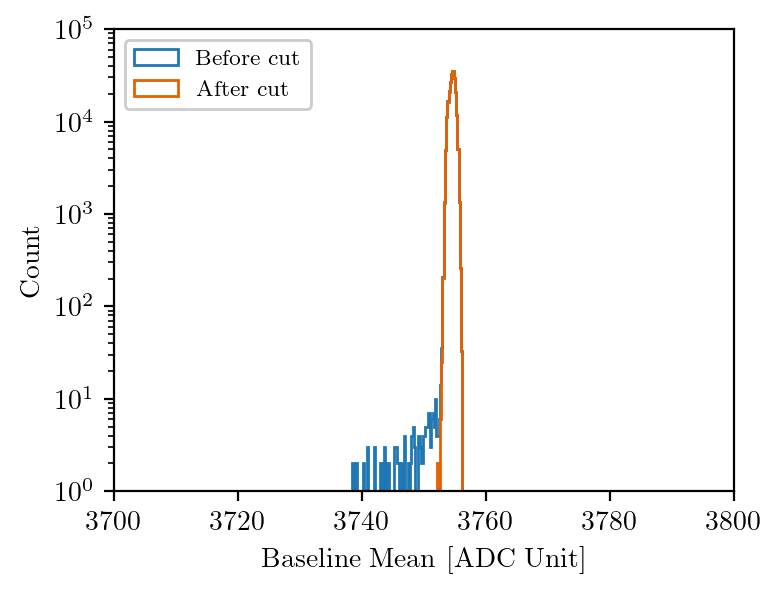

In [12]:
i=0
ch=0
dset = ds1122bot[i].ch[ch]

nbins = 500
range_min = 3700
range_max = 3800
bin_width = (range_max-range_min)/nbins

bsl_avg_cut = []
for ev,avg in enumerate(dset.baseline_avg):
    if dset.baseline_std[ev]<2.5:
        bsl_avg_cut.append(avg)

plt.hist(dset.baseline_avg, label='Before cut', bins=np.linspace(range_min, range_max, nbins+1), histtype='step')
plt.hist(bsl_avg_cut, label='After cut', bins=np.linspace(range_min, range_max, nbins+1), histtype='step')
plt.legend()
plt.yscale('log')
plt.xlabel('Baseline Mean [ADC Unit]')
plt.ylabel('Count')

## Filtered amplitude and direct crosstalk (DiCT)
Repeat analysis

<Figure size 1800x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

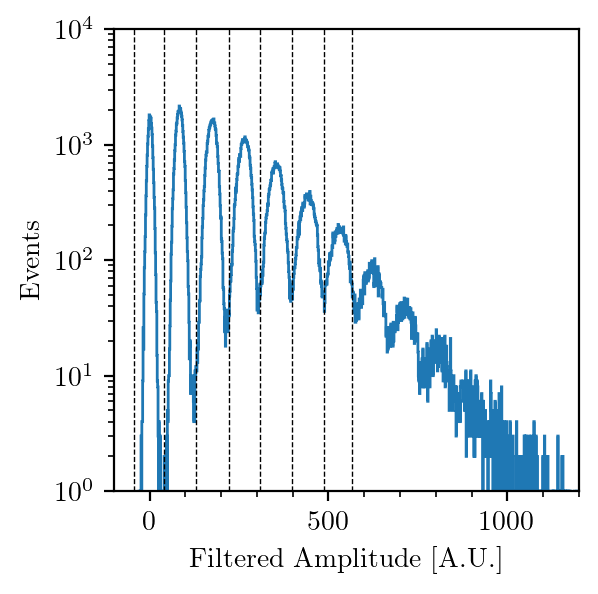

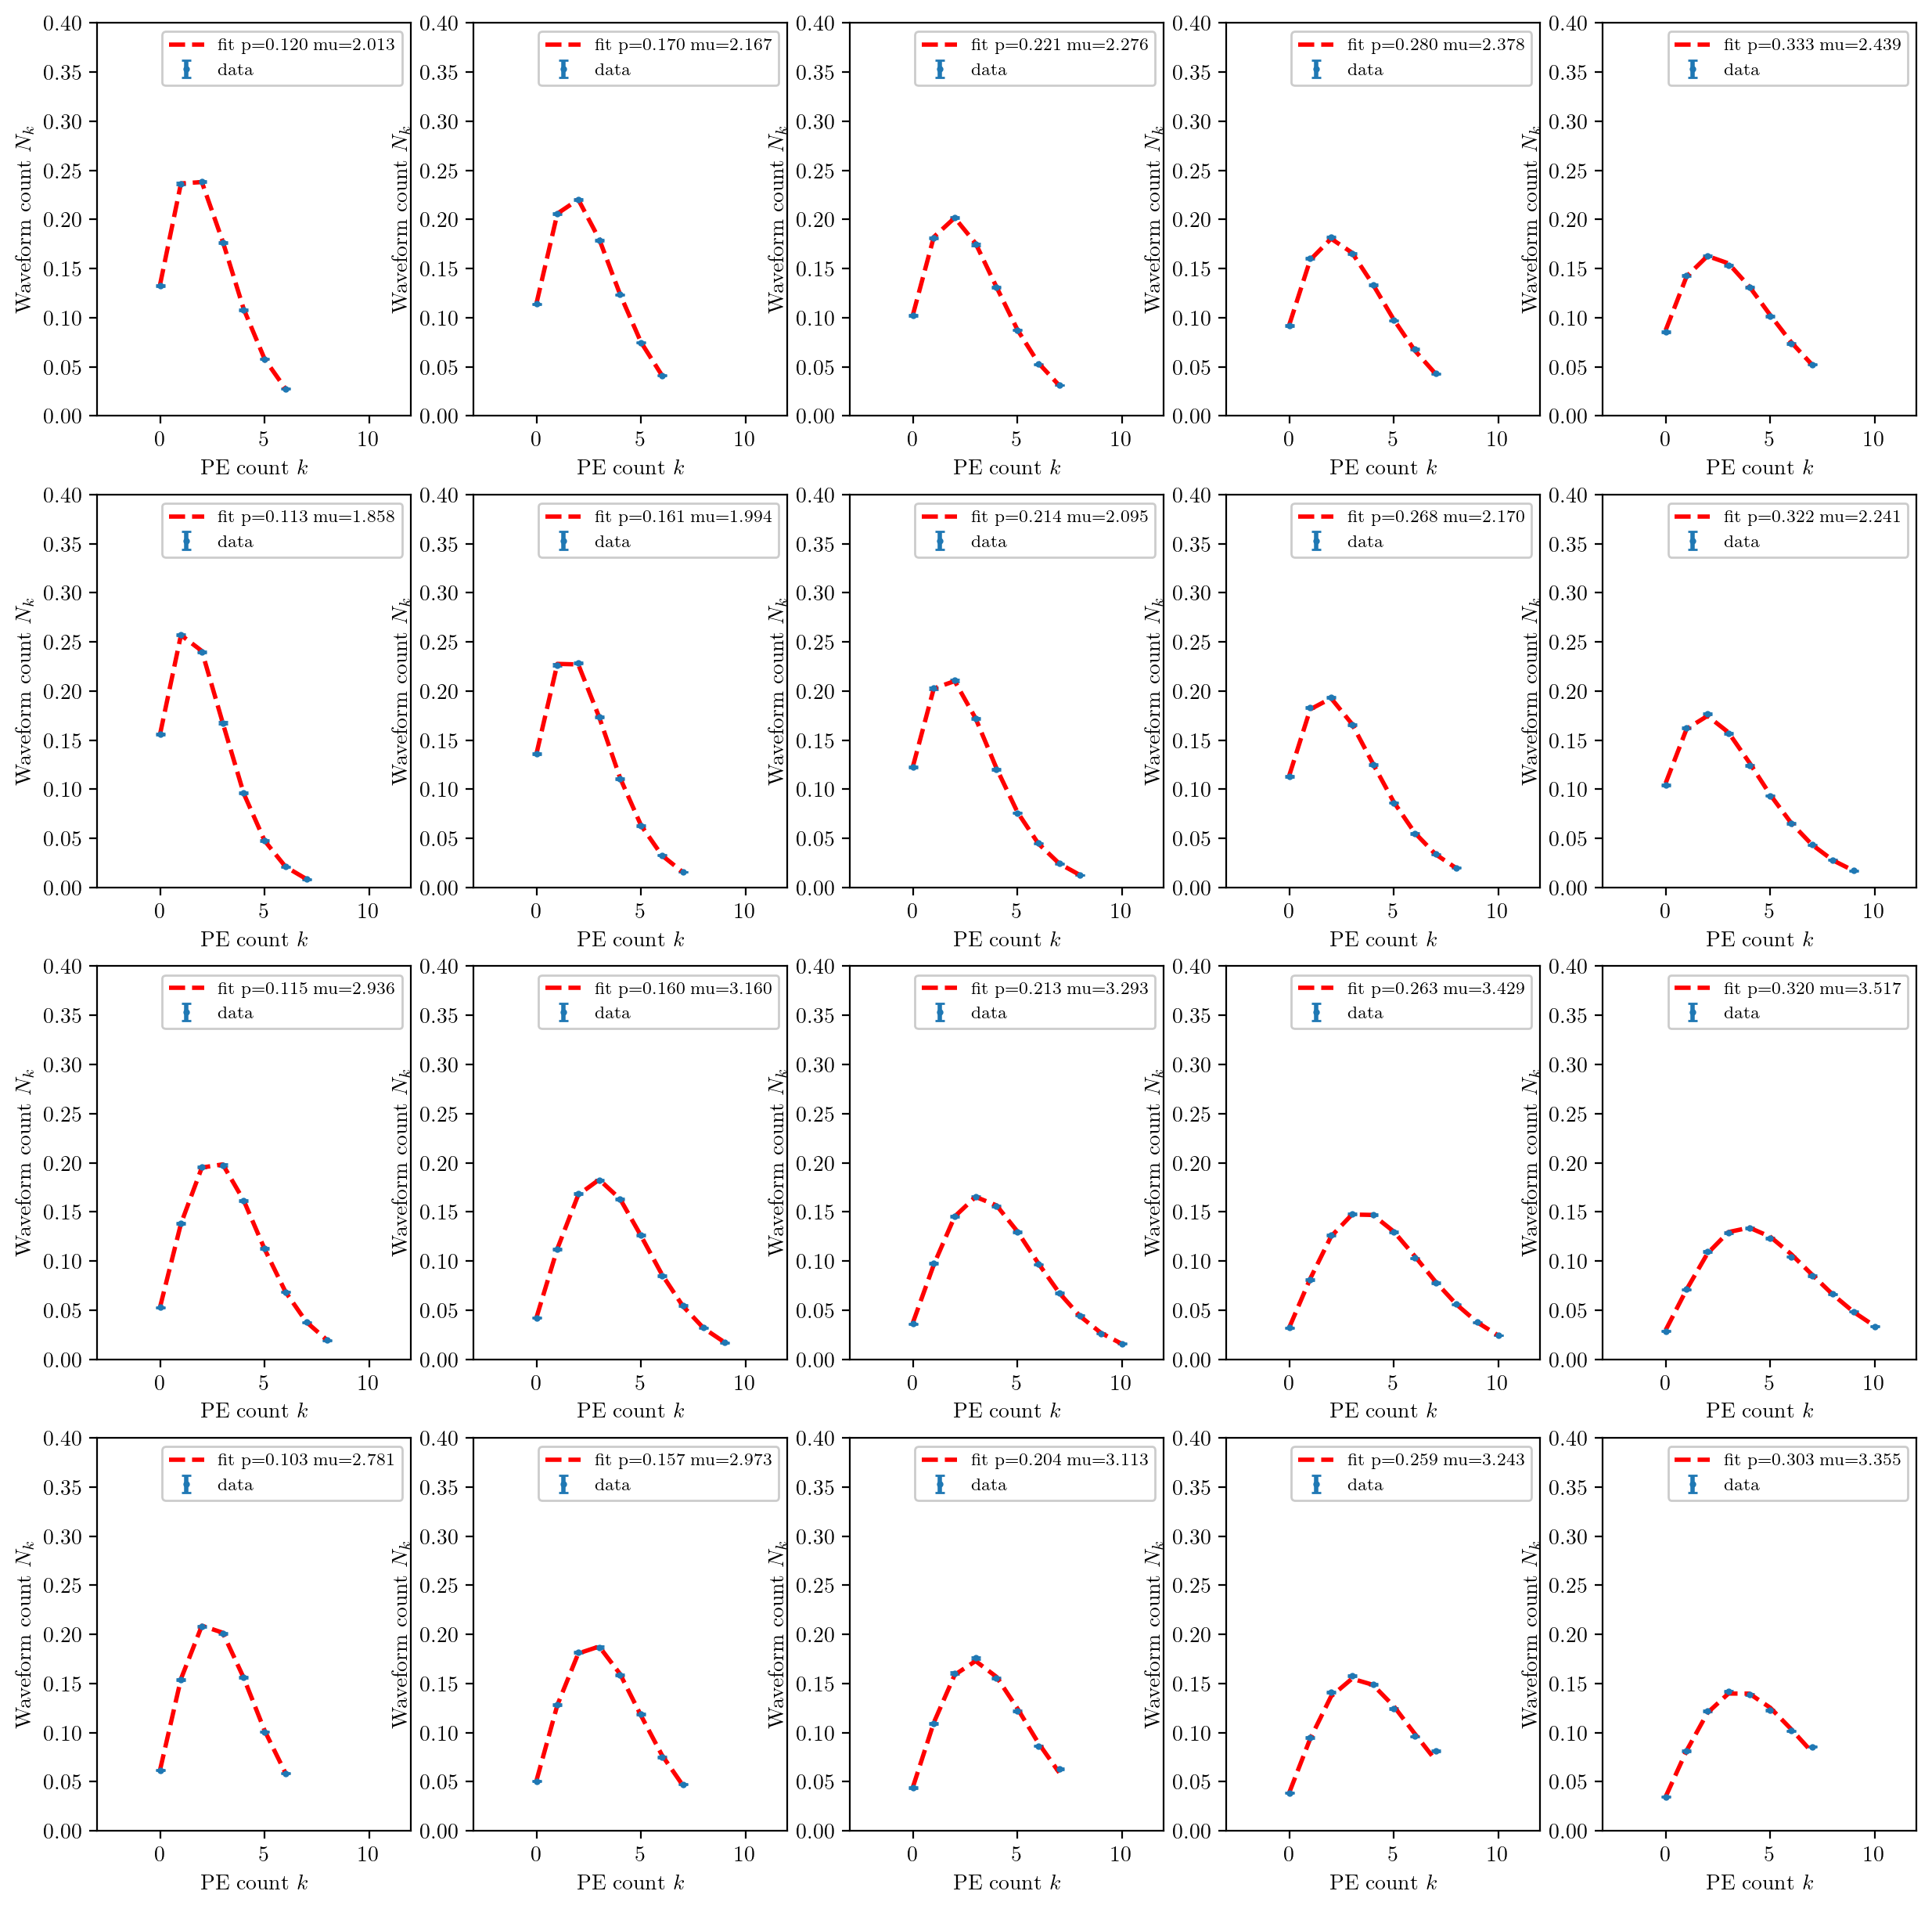

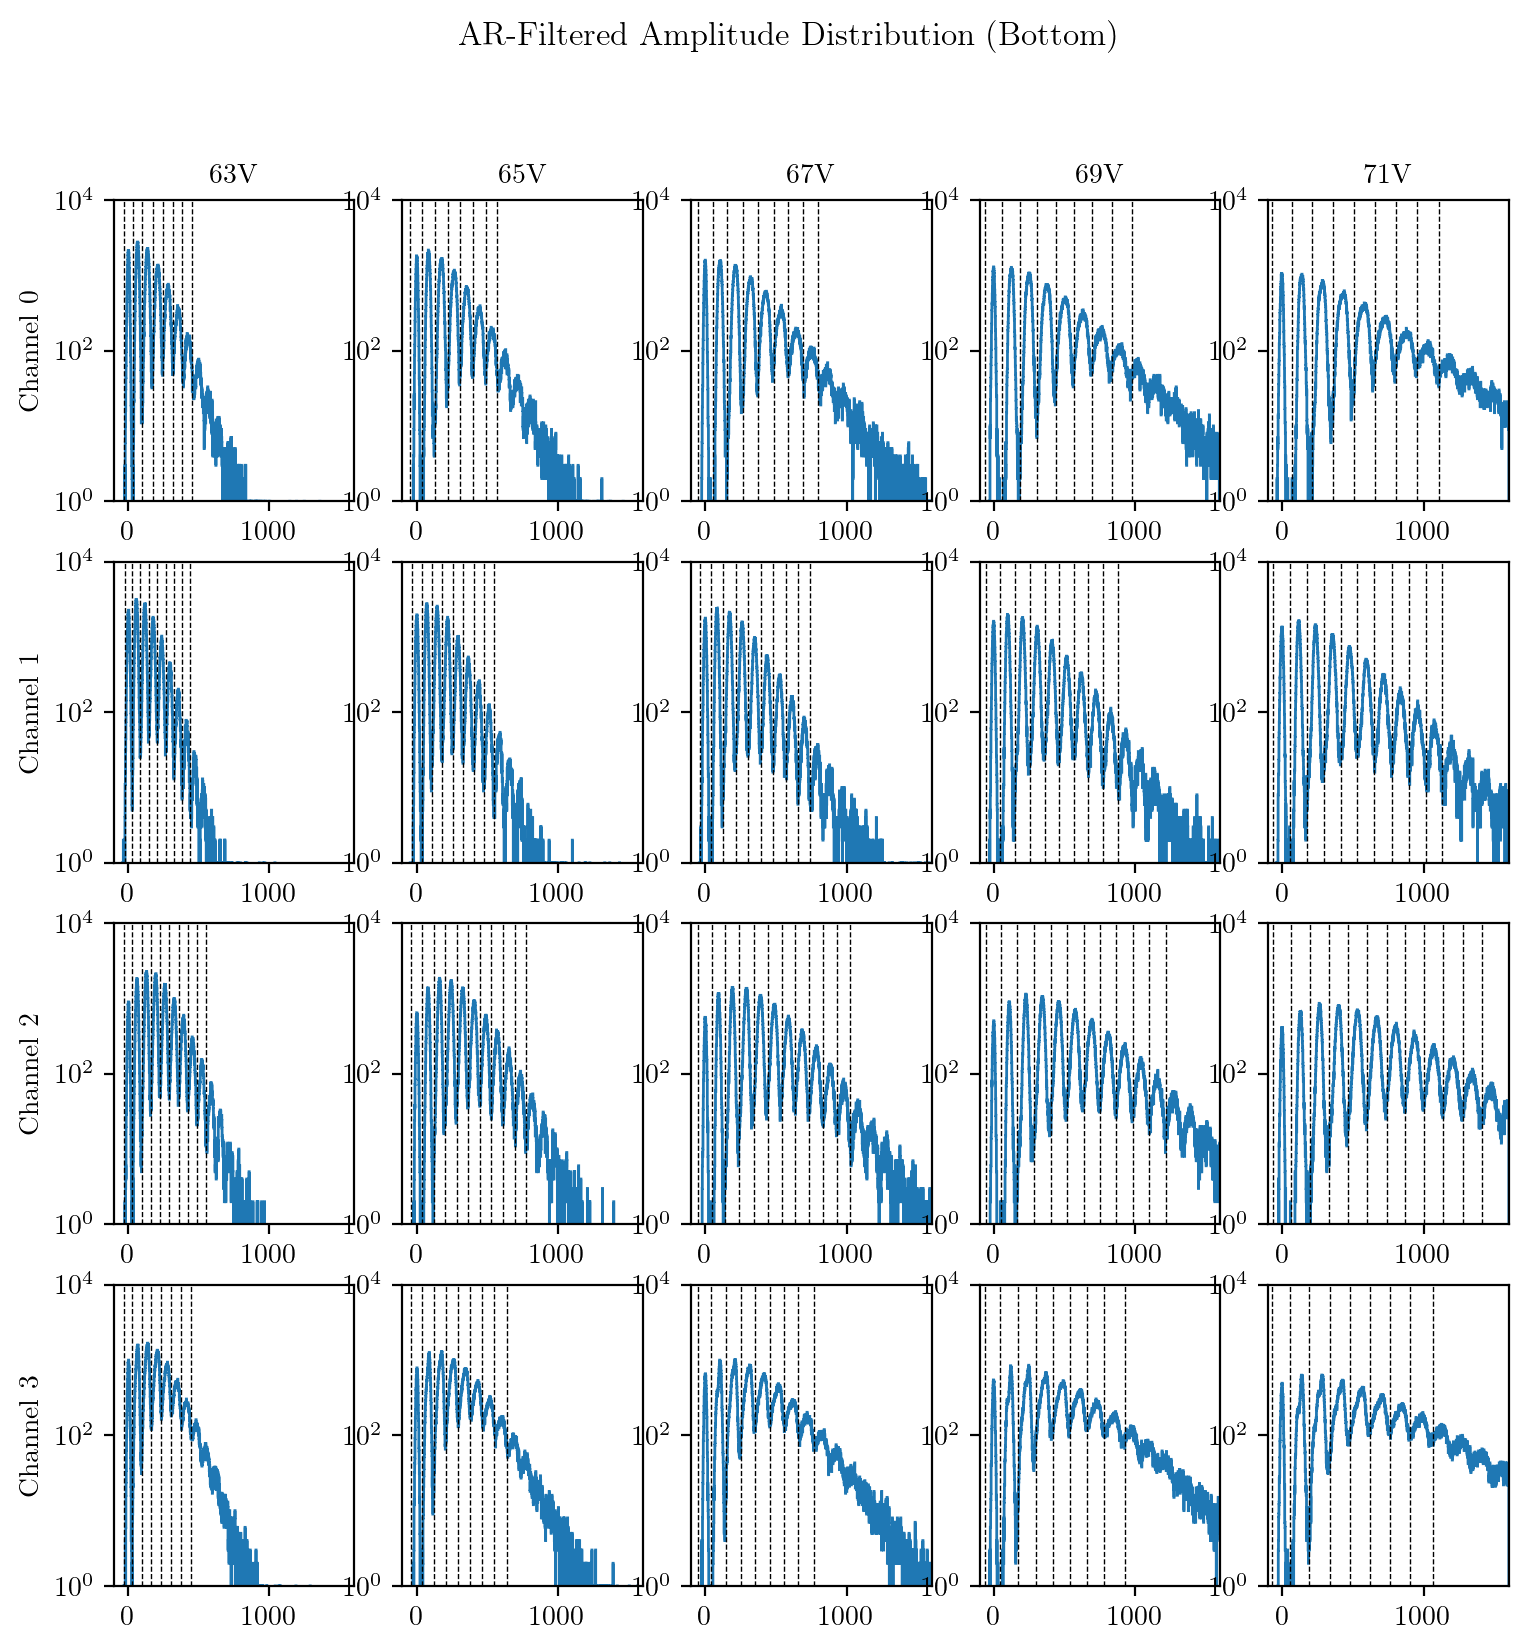

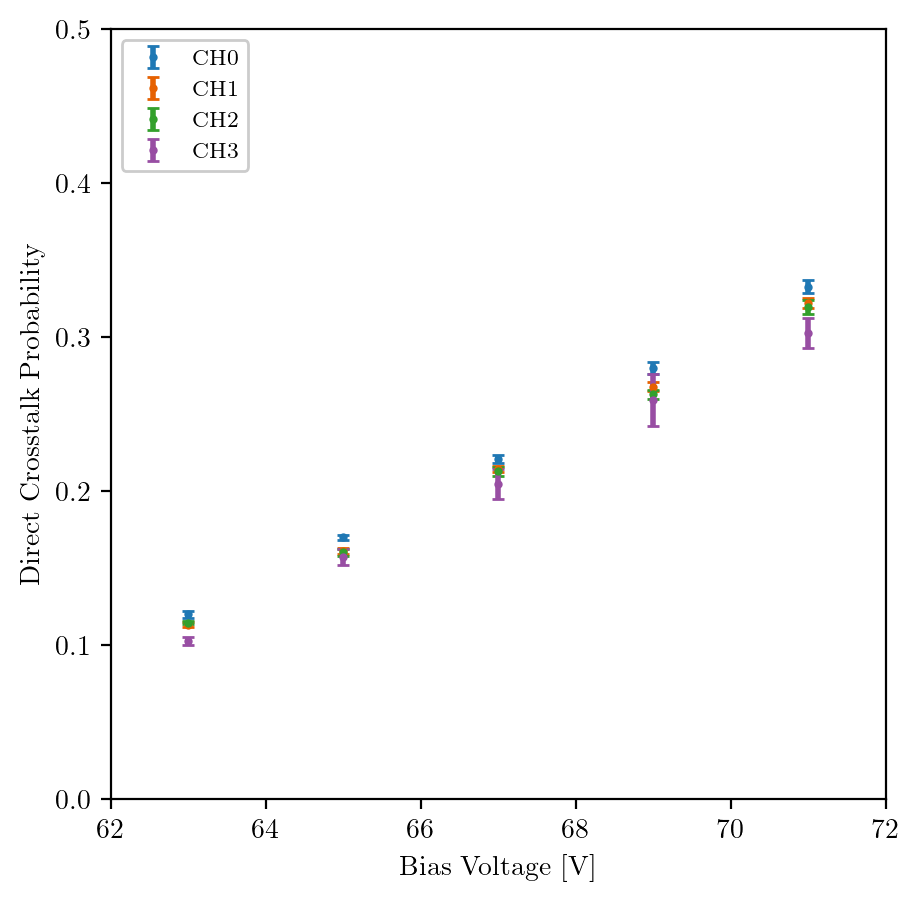

In [13]:
plt.figure(0,figsize=(9,9)) # for filtered amplitude histograms
plt.figure(1,figsize=(9,3)) # for breakdown voltage fit
plt.figure(2,figsize=(15,15)) # for Vinogradov fit
plt.figure(3,figsize=(5,5)) # for crosstalk summary
plt.figure(4,figsize=(3,3)) # finger plot for a particular channel
plt.figure(5,figsize=(3,3)) # dict fit for a particular channel
chn = 0
iv = 1
ivv = 4
Vbd_famp_bot = np.zeros((4,2))
for ch in range(4):
    for i,data in enumerate(ds1122bot):  
        #filtered amplitude histogram
        nbins=1500
        range_min = -1e2
        range_max = 1.6e3
        bin_width=(range_max-range_min)/nbins
        data.ch[ch].get_famp_hist(bin=[range_min,range_max,nbins])
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.stairs(data.ch[ch].famp_hist, data.ch[ch].famp_hist_bin)
        plt.yscale('log')
        plt.xlim(data.ch[ch].famp_hist_bin[0], data.ch[ch].famp_hist_bin[-1])
        plt.ylim(1, 1e4)
        # find pe peaks in histograms
        data.ch[ch].find_histo_peaks(hist='famp', thre=0, prom=70, wid=10, dist=8)
        # fit pe peaks with Gaussian
        # if ch==3 and (i==3 or i==4):
        #     min_bins, max_bins = data.ch[ch].fit_histo_peaks(hist='famp', bad=True)
        # else:
        #     min_bins, max_bins = data.ch[ch].fit_histo_peaks(hist='famp')
        # npe = len(data.ch[ch].famp_hist_fit)
        # for ipe in range(npe):
        #     popt = [data.ch[ch].famp_hist_fit[ipe][ipar][0] for ipar in range(3)]
        #     plt.plot(data.ch[ch].famp_hist_bin[min_bins[ipe]:max_bins[ipe]], gauss(data.ch[ch].famp_hist_bin[min_bins[ipe]:max_bins[ipe]], *popt), color=colors[1], lw=1, zorder=10)
        #     if ipe==0:
        #         print('A1={:.3f} sigma1={:.3f}'.format(data.ch[ch].famp_hist_fit[0][1][0], data.ch[ch].famp_hist_fit[0][2][0]))
        #fit pe-mean vs pe with linear
        # Afilt = [[data.ch[ch].famp_hist_fit[k][1][0], data.ch[ch].famp_hist_fit[k][1][1]] for k in range(npe)]
        # xlin = np.linspace(1,npe,npe)
        # ylin = np.array(Afilt)[:,0]
        # popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], sigma=np.array(Afilt)[:,1], maxfev=10000)          
        # data.ch[ch].set_spe_gain(q_a=[popt[0], np.sqrt(pcov[0,0])]) # This is Q_A
        
        #Use Gaussian normalization
        # N_k = [data.ch[ch].famp_hist_fit[k][0] for k in range(npe)]
        #Use histogram integral
        P_k = []
        npe = len(data.ch[ch].peaks)
        pe_cuts = []
        for ipe in range(npe+1):
            # if ipe==0:
            #     min_ipe = int((0.5*data.ch[ch].famp_hist_fit[ipe][1][0]-range_min)/bin_width)
            # else:
            #     min_ipe = int((0.5*(data.ch[ch].famp_hist_fit[ipe][1][0]+data.ch[ch].famp_hist_fit[ipe-1][1][0])-range_min)/bin_width)
            # if ipe==npe-1:
            #     max_ipe = int((1.5*data.ch[ch].famp_hist_fit[ipe][1][0]-0.5*data.ch[ch].famp_hist_fit[ipe-1][1][0]-range_min)/bin_width)
            # else:
            #     max_ipe = int((0.5*(data.ch[ch].famp_hist_fit[ipe+1][1][0]+data.ch[ch].famp_hist_fit[ipe][1][0])-range_min)/bin_width)
            if ch!=3:
                if ipe==0:
                    pe_cuts.append(int(1.5*data.ch[ch].peaks[0]-0.5*data.ch[ch].peaks[1]))
                elif ipe==npe:
                    pe_cuts.append(int(1.5*data.ch[ch].peaks[-1]-0.5*data.ch[ch].peaks[-2]))
                else:
                    pe_cuts.append(int(0.5*(data.ch[ch].peaks[ipe]+data.ch[ch].peaks[ipe-1])))
            else:
                if ipe==0:
                    pe_cuts.append(int(1.5*data.ch[ch].peaks[0]-0.5*data.ch[ch].peaks[1]))
                elif ipe==npe:
                    pe_cuts.append(int(1.5*data.ch[ch].peaks[-1]-0.5*data.ch[ch].peaks[-2]))
                else:
                    pe_cuts.append(int(0.4*data.ch[ch].peaks[ipe]+0.6*data.ch[ch].peaks[ipe-1]))
            # N_k.append([np.sum(data.ch[ch].famp_hist[min_ipe:max_ipe]), np.sqrt(np.sum(data.ch[ch].famp_hist[min_ipe:max_ipe]))])
            plt.plot([pe_cuts[ipe]*bin_width+range_min, pe_cuts[ipe]*bin_width+range_min], [1,1e4], 'k--', linewidth=0.5)
            if ipe>0:
                P_k.append([np.sum(data.ch[ch].famp_hist[pe_cuts[ipe-1]:pe_cuts[ipe]])/data.ch[ch].nevents_aftercut, np.sqrt(np.sum(data.ch[ch].famp_hist[pe_cuts[ipe-1]:pe_cuts[ipe]]))/data.ch[ch].nevents_aftercut])
        # plot one particular channel
        if ch==chn and i==iv:
            plt.figure(4)
            plt.stairs(data.ch[ch].famp_hist, data.ch[ch].famp_hist_bin)
            plt.yscale('log')
            for pe_cut in pe_cuts:
                plt.plot([pe_cut*bin_width+range_min, pe_cut*bin_width+range_min], [1,1e4], 'k--', linewidth=0.5)
            plt.xlabel('Filtered Amplitude [A.U.]')
            plt.ylabel('Events')
            # plt.suptitle('Top Ch{} {}V'.format(ch, bias[i]))
            plt.xlim(data.ch[ch].famp_hist_bin[0], 1200)
            plt.ylim(1, 1e4)
            plt.minorticks_on()
        #Vinogradov fit
        plt.figure(2)
        plt.subplot(4,5,ch*5+i+1)
        plt.errorbar(np.arange(len(P_k)), np.array(P_k)[:,0], yerr=np.array(P_k)[:,1], fmt='o', markersize=2, label='data')
        popt,pcov = curve_fit(compound_poisson, list(np.arange(len(P_k))), np.array(P_k)[:,0], p0=[3, 0.2], sigma=np.array(P_k)[:,1], maxfev=10000)
        # print('mu={:.3f} p={:.3f}'.format(popt[1], popt[2]))
        data.ch[ch].set_correlated_noise(ct=[popt[1],np.sqrt(pcov[1,1])])
        plt.plot(np.arange(len(P_k)), compound_poisson(np.arange(len(P_k)),*popt), 'r--', label='fit p={:.3f} mu={:.3f}'.format(popt[1],popt[0]))
        plt.ylim(0,0.4)
        plt.xlim(-3,12)
        plt.xlabel(r'PE count $k$')
        plt.ylabel(r'Waveform count $N_k$')
        plt.legend(loc='upper right')
    # plot crosstalk
    plt.figure(3)
    plt.errorbar(bias, [data.ch[ch].ct[0] for data in ds1122bot], yerr=[data.ch[ch].ct[1] for data in ds1122bot], label='CH{}'.format(ch), fmt='o', markersize=2)

    #breakdown voltage fit and plot
    # xlin = bias
    # ylin = [data.ch[ch].q_a[0] for data in ds1122bot]
    # err = [data.ch[ch].q_a[1] for data in ds1122bot]
    # popt,pcov = curve_fit(line_vbd, xlin, ylin, sigma=err, p0=[20, 55], maxfev=10000)
    # print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    # Vbd_famp_bot[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    # plt.figure(1)
    # plt.subplot(1,4,ch+1)
    # plt.title('Channel {}'.format(ch))
    # plt.ylabel('Gain (A.U.)')
    # plt.xlabel('Bias (V)')
    # plt.errorbar(xlin,ylin,yerr=err,fmt='o', markersize=2)
    # plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    # plt.xlim(50,80)
    # plt.ylim(0,250)
        
plt.figure(0)
plt.suptitle('AR-Filtered Amplitude Distribution (Bottom)')
plt.savefig('plots/sipm/famp_histo_bot_1122.pdf')
# plt.figure(1)
# plt.suptitle('Breakdown Voltage (Bottom)')
# plt.savefig('plots/sipm/gain_bias_famp_bot_1122.pdf')
plt.figure(3)
plt.legend()
plt.xlabel('Bias Voltage [V]')
plt.ylabel('Direct Crosstalk Probability')
plt.xlim(62,72)
plt.ylim(0, 0.5)
plt.savefig('plots/sipm/dict_bot_1122.pdf')

## Afterpulsing
Repeat analysis


Channel 0 Vbd=54.450+/-0.240V slope=51.725+/-1.060
Channel 1 Vbd=53.388+/-0.334V slope=43.533+/-1.135
Channel 2 Vbd=53.551+/-0.285V slope=46.822+/-0.929
Channel 3 Vbd=53.397+/-0.451V slope=46.800+/-1.579


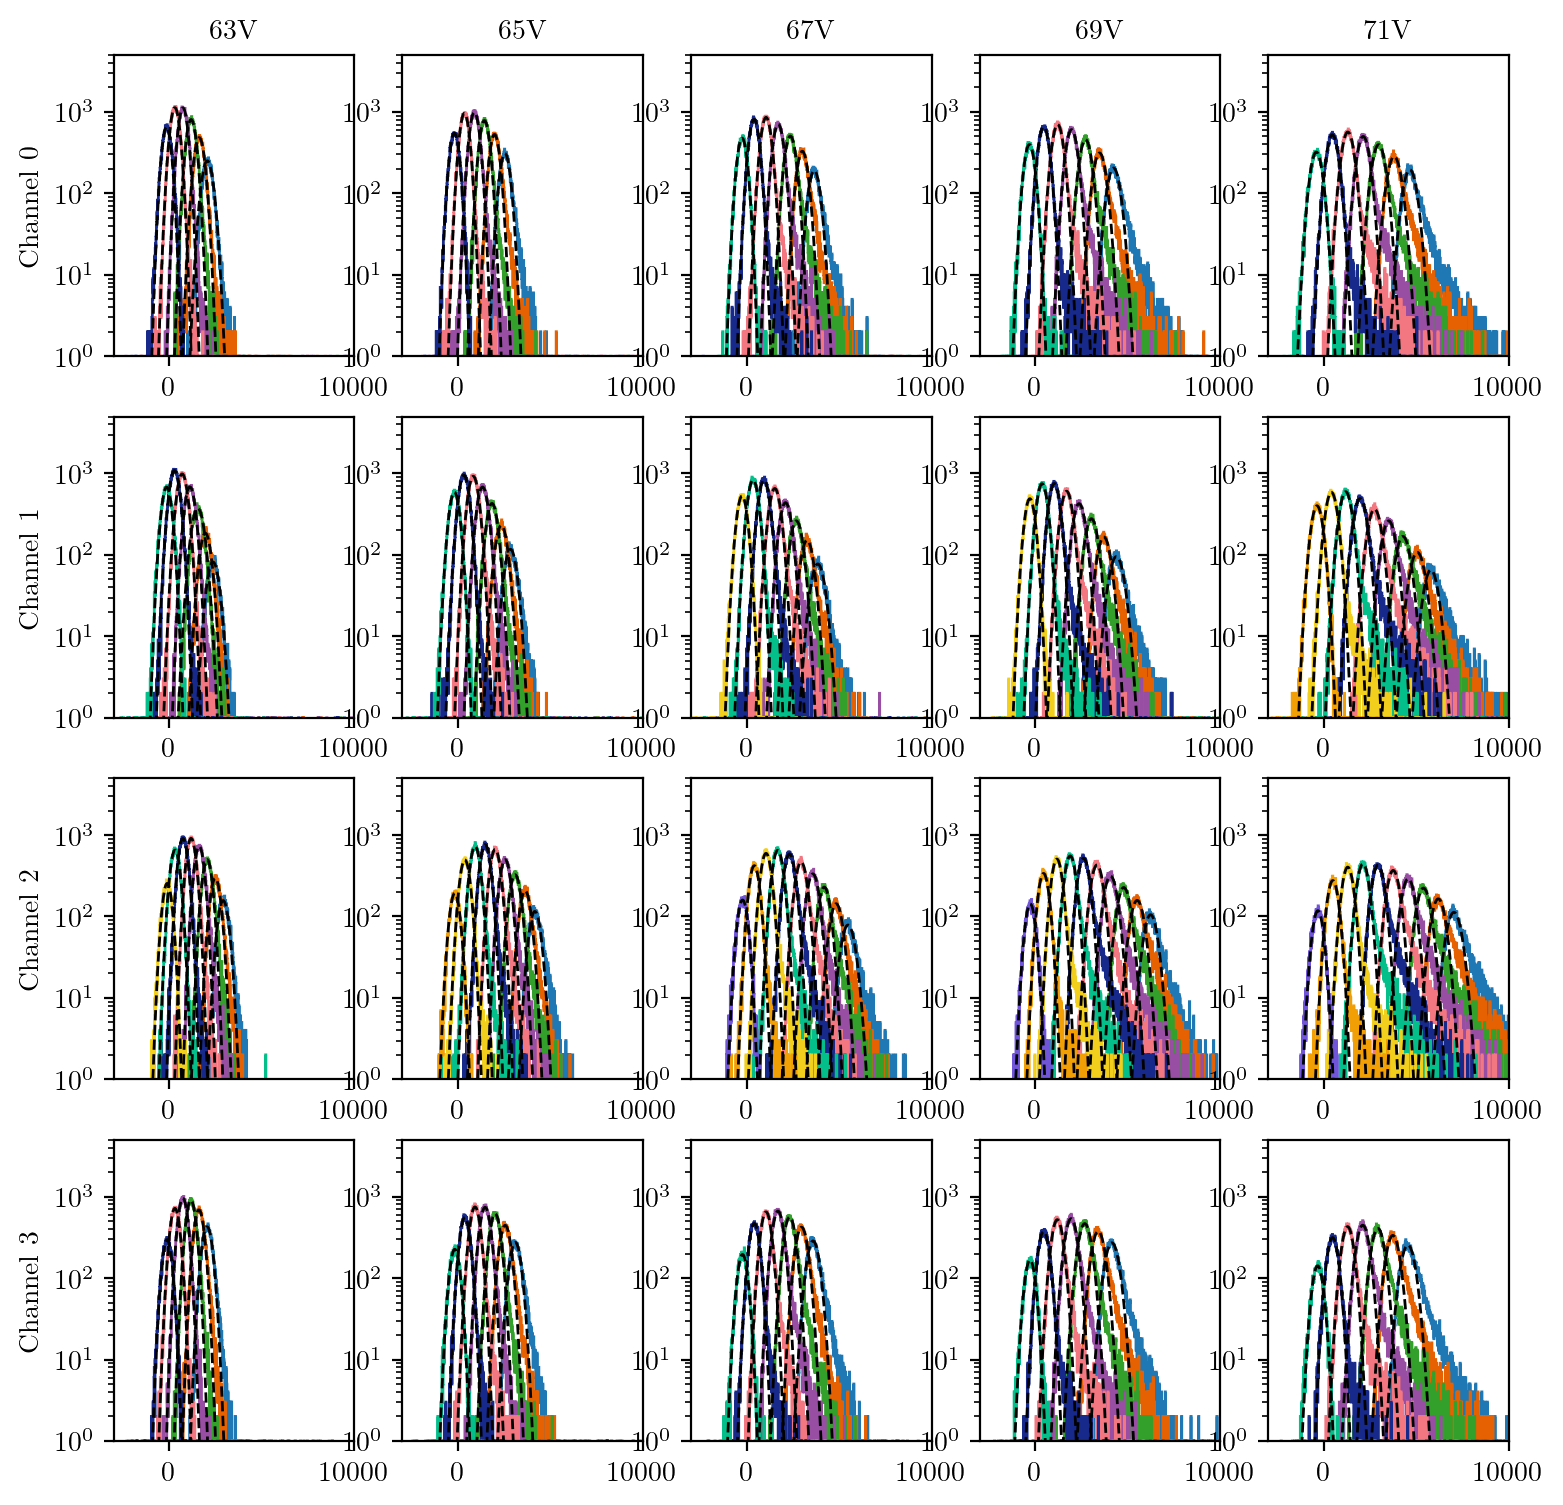

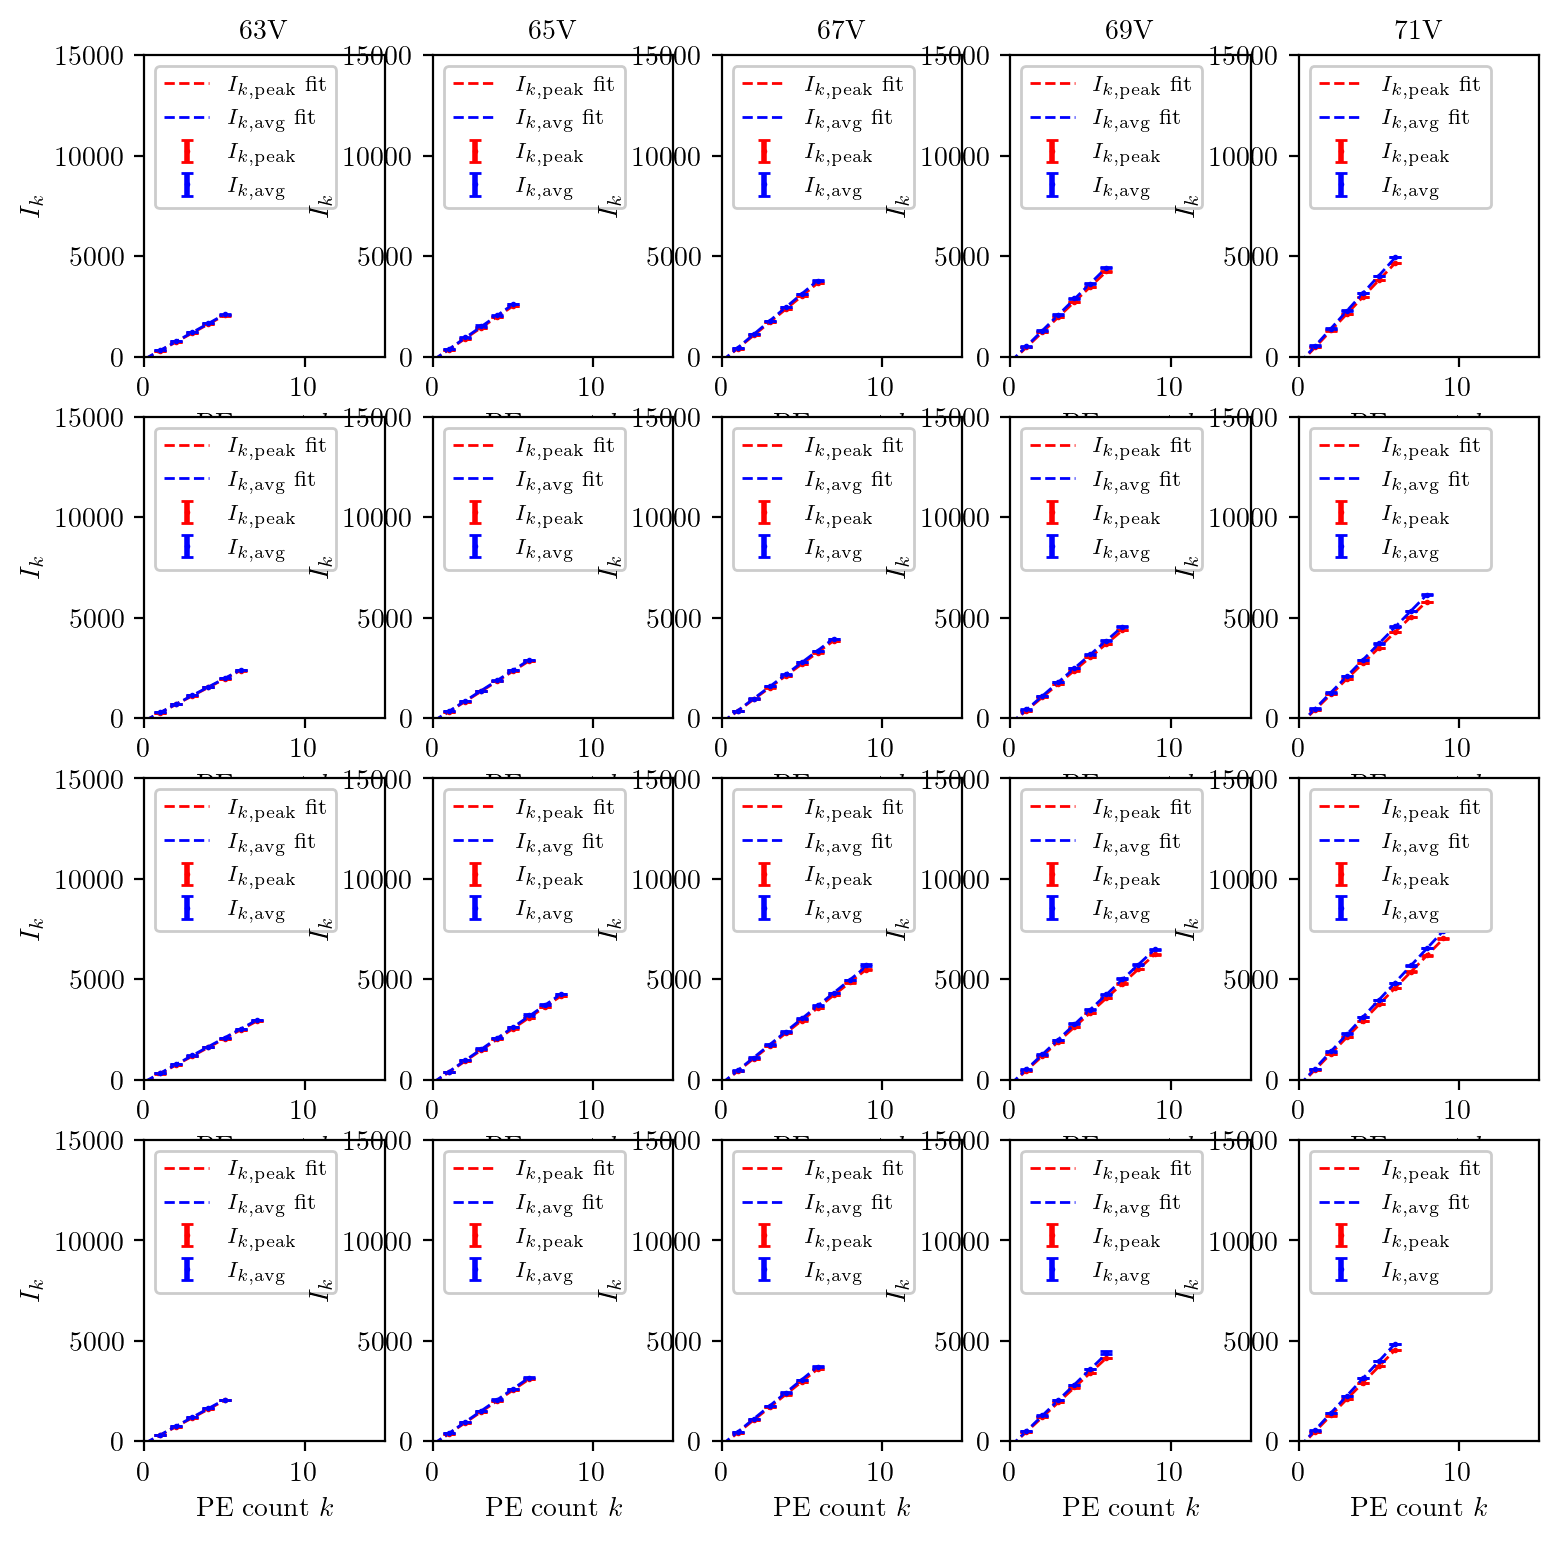

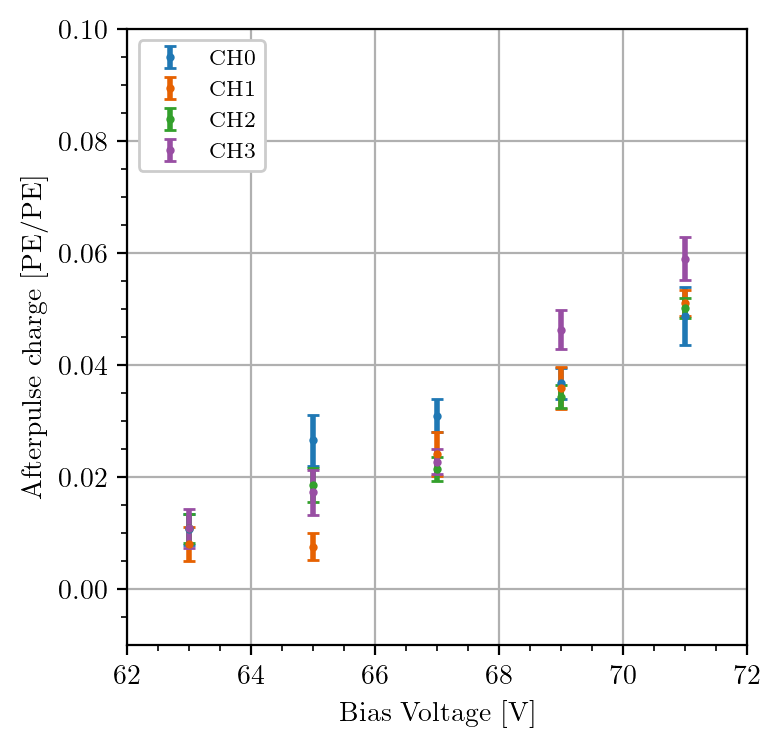

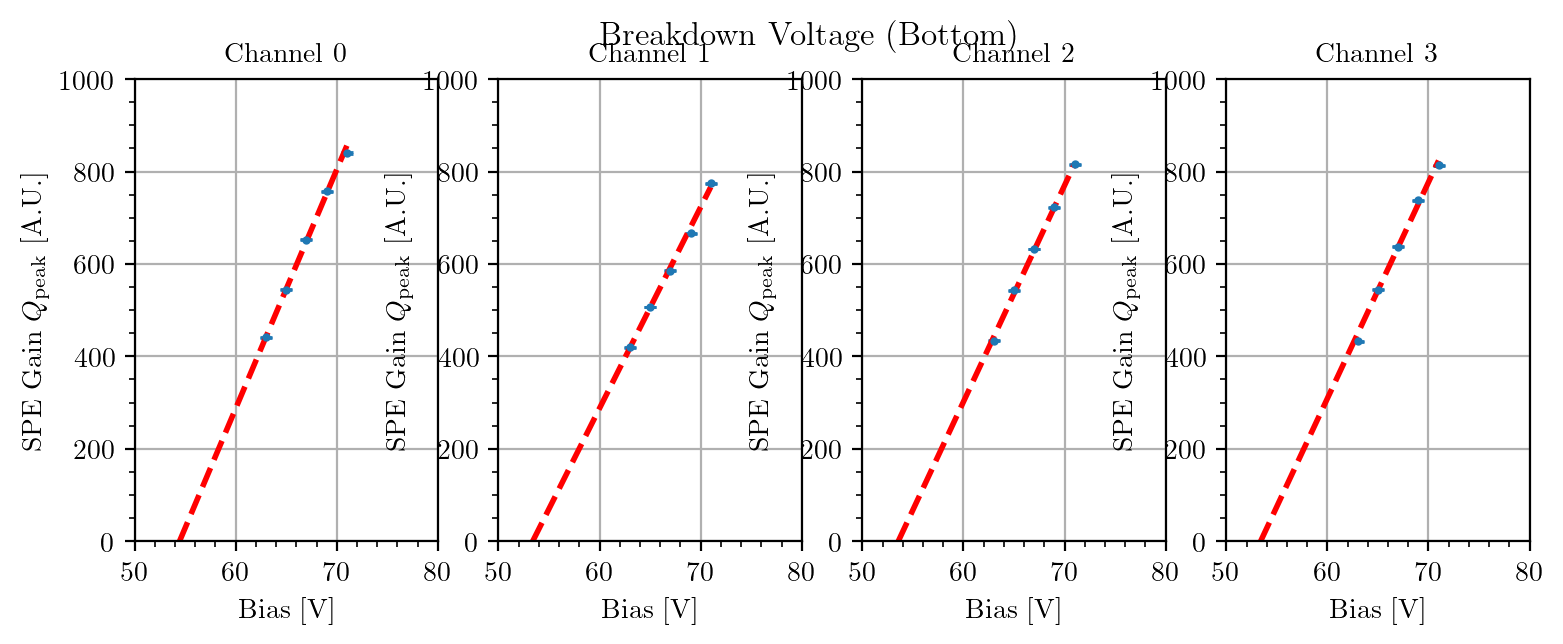

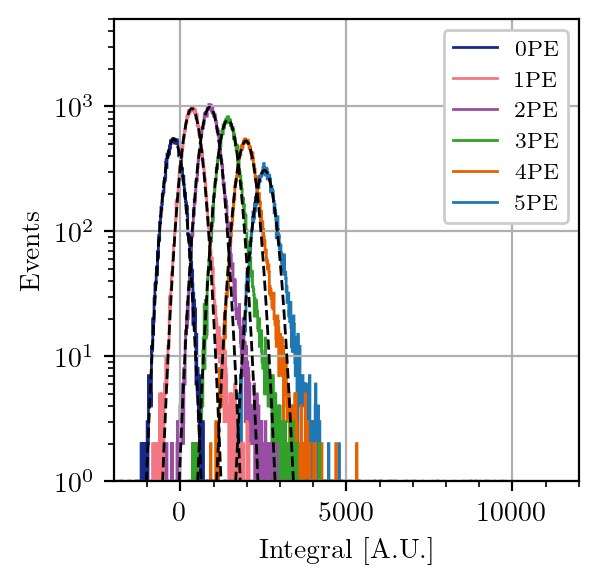

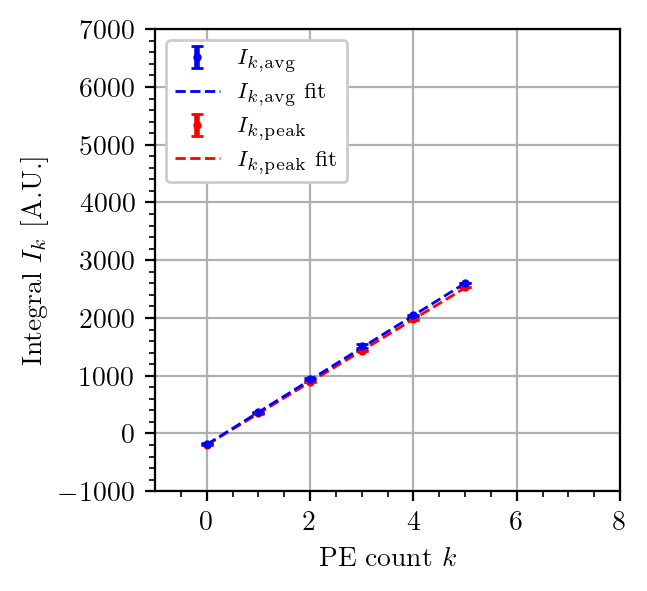

In [14]:
plt.figure(0,figsize=(9,9)) # for I_k histograms
plt.figure(1,figsize=(9,9)) # for I_k fits
plt.figure(2,figsize=(4,4)) # for afterpulse
plt.figure(3,figsize=(9,3)) # for Vbd
plt.figure(4,figsize=(3,3)) # histogram for one particular channel
plt.figure(5,figsize=(3,3)) # gain-bias fit for one particular channel
Vbd_charge_bot = np.zeros((4,2))
x_min=-3000
x_max=1e4
n_bins=1000
bin_width = (x_max-x_min)/n_bins
chn = 0
iv = 1
for ch in range(4):
    for i,data in enumerate(ds1122bot):
        Ik_peak = [] 
        Ik_avg = []
        data.ch[ch].get_afterpulse_charge(bin=[x_min, x_max, n_bins], bad=(ch==3))
        #histogram and Gaussian fit
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        last_w = int(0.7*np.std(data.ch[ch].ap_charge[-1])/bin_width)
        for j in np.arange(len(data.ch[ch].ap_charge)-2,-1,-1):
            plt.stairs(data.ch[ch].ap_charge_hist[j], data.ch[ch].ap_charge_hist_bin[j])
            Ik_avg.append([np.mean(data.ch[ch].ap_charge[j]), np.std(data.ch[ch].ap_charge[j])/np.sqrt(len(data.ch[ch].ap_charge[j]))])
            w = int(0.7*np.std(data.ch[ch].ap_charge[j])/bin_width) # in bins
            p = np.argmax(data.ch[ch].ap_charge_hist[j]) # in bins
            # print('w={} last_w={}'.format(w, last_w))
            w=min(last_w,50) # something weird happened so I need to do this
            # print('ch{} {}V {}PE {}-{}'.format(ch, bias[i], j, p-w,p+w))
            last_w = w
            popt,pcov = curve_fit(gauss, data.ch[ch].ap_charge_hist_bin[j][p-w:p+w], data.ch[ch].ap_charge_hist[j][p-w:p+w], p0=[np.max(data.ch[ch].ap_charge_hist[j])*w*bin_width,p*bin_width+x_min,w*bin_width], sigma=np.sqrt(data.ch[ch].ap_charge_hist[j][p-w:p+w]), maxfev=100000)
            plt.plot(data.ch[ch].ap_charge_hist_bin[j][:-1], gauss(data.ch[ch].ap_charge_hist_bin[j][:-1], *popt), 'k--', linewidth=1)
            Ik_peak.append([popt[1],np.sqrt(pcov[1,1])])
            if ch==chn and i==iv:
                plt.figure(4)
                plt.stairs(data.ch[ch].ap_charge_hist[j], data.ch[ch].ap_charge_hist_bin[j], label='{}PE'.format(j))
                plt.plot(data.ch[ch].ap_charge_hist_bin[j][:-1], gauss(data.ch[ch].ap_charge_hist_bin[j][:-1], *popt), 'k--', linewidth=1)
                plt.legend(loc='upper right')
                plt.minorticks_on()
                plt.grid()
            plt.figure(0)
            
        plt.xlim(data.ch[ch].ap_charge_hist_bin[0][0], data.ch[ch].ap_charge_hist_bin[0][-1])
        plt.ylim(1,5e3)
        plt.yscale('log')
        # plot mu-pe vs avg-pe
        Ik_peak = list(reversed(Ik_peak))
        Ik_avg = list(reversed(Ik_avg))
        plt.figure(1)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        # Q_peak fit
        plt.errorbar(np.arange(len(data.ch[ch].ap_charge)-1), np.array(Ik_peak)[:,0], yerr=np.array(Ik_peak)[:,1], fmt='r.', markersize=2, label=r'$I_{k,\rm peak}$')
        popt,pcov=curve_fit(line,np.arange(len(data.ch[ch].ap_charge)-1), np.array(Ik_peak)[:,0], p0=[500,0], sigma=np.array(Ik_peak)[:,1], maxfev=10000)
        # print('Q_peak = {:.3f}+/-{:.3f}'.format(popt[0], np.sqrt(pcov[0,0])))
        data.ch[ch].set_spe_gain(q_peak=[popt[0],np.sqrt(pcov[0,0])])
        plt.plot(np.arange(len(data.ch[ch].ap_charge)-1), line(np.arange(len(data.ch[ch].ap_charge)-1), *popt), 'r--', label=r'$I_{k,\rm peak}$ fit', linewidth=1)
        if ch==chn and i==iv:
            plt.figure(5)
            plt.errorbar(np.arange(len(data.ch[ch].ap_charge)-1), np.array(Ik_peak)[:,0], yerr=np.array(Ik_peak)[:,1], fmt='ro', markersize=2, label=r'$I_{k,\rm peak}$')
            plt.plot(np.arange(len(data.ch[ch].ap_charge)-1), line(np.arange(len(data.ch[ch].ap_charge)-1), *popt), 'r--', label=r'$I_{k,\rm peak}$ fit', linewidth=1)
        plt.figure(1)
        # Q_avg fit
        plt.errorbar(np.arange(len(data.ch[ch].ap_charge)-1), np.array(Ik_avg)[:,0], yerr=np.array(Ik_avg)[:,1], fmt='b.', markersize=2, label=r'$I_{k,\rm avg}$')
        popt_,pcov_=curve_fit(line,np.arange(len(data.ch[ch].ap_charge)-1),np.array(Ik_avg)[:,0], p0=[500,0], sigma=np.array(Ik_avg)[:,1], maxfev=10000)
        # print('Q_avg = {:.3f}+/-{:.3f}'.format(popt_[0], np.sqrt(pcov_[0,0])))
        data.ch[ch].set_spe_gain(q_avg=[popt_[0],np.sqrt(pcov_[0,0])])
        plt.plot(np.arange(len(data.ch[ch].ap_charge)-1), line(np.arange(len(data.ch[ch].ap_charge)-1), *popt_), 'b--', label=r'$I_{k,\rm avg}$ fit', linewidth=1)
        if ch==chn and i==iv:
            plt.figure(5)
            plt.errorbar(np.arange(len(data.ch[ch].ap_charge)-1), np.array(Ik_avg)[:,0], yerr=np.array(Ik_avg)[:,1], fmt='bo', markersize=2, label=r'$I_{k,\rm avg}$')
            plt.plot(np.arange(len(data.ch[ch].ap_charge)-1), line(np.arange(len(data.ch[ch].ap_charge)-1), *popt_), 'b--', label=r'$I_{k,\rm avg}$ fit', linewidth=1)
        plt.figure(1)

        plt.xlabel(r'PE count $k$')
        plt.ylabel(r'$I_k$')
        plt.xlim(0,15)
        plt.ylim(0,1.5e4)
        plt.legend()
        data.ch[ch].set_correlated_noise(ap=[popt_[0]/popt[0]-1, popt_[0]/popt[0]*np.sqrt(pcov[0,0]/popt[0]**2+pcov_[0,0]/popt_[0]**2)])

    # plot after-pulses
    plt.figure(2)
    plt.errorbar(bias, [data.ch[ch].ap[0] for data in ds1122bot], yerr=[data.ch[ch].ap[1] for data in ds1122bot], label='CH{}'.format(ch), fmt='o', markersize=2)

    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].q_peak[0] for data in ds1122bot]
    err = [data.ch[ch].q_peak[1] for data in ds1122bot]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, sigma=err, p0=[100, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    Vbd_charge_bot[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    plt.figure(3)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel(r'SPE Gain $Q_{\rm peak}$ [A.U.]')
    plt.xlabel('Bias [V]')
    plt.errorbar(xlin,ylin,yerr=err,fmt='o', markersize=2)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.minorticks_on()
    plt.grid()
    plt.xlim(50,80)
    plt.ylim(0,1000)

plt.figure(2)
plt.legend()
plt.minorticks_on()
plt.grid()
plt.xlabel('Bias Voltage [V]')
plt.ylabel('Afterpulse charge [PE/PE]')
plt.xlim(62,72)
plt.ylim(-0.01, 0.1)
plt.savefig('plots/sipm/afterpulse_bias_bot_1122.pdf')
plt.figure(3)
plt.suptitle('Breakdown Voltage (Bottom)')
plt.savefig('plots/sipm/gain_bias_charge_bot_1122.pdf')

plt.figure(4)
plt.yscale('log')
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = np.arange(len(labels)-1, -1, -1)
#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='upper right')
plt.minorticks_on()
plt.grid()
plt.ylim(1e0, 5e3)
plt.xlim(-2e3, 1.2e4)
plt.xlabel('Integral [A.U.]')
plt.ylabel('Events')

plt.figure(5)
plt.xlabel(r'PE count $k$')
plt.ylabel(r'Integral $I_k$ [A.U.]')
plt.xlim(-1,8)
plt.ylim(-1e3,7e3)
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [3,1,2,0]
#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='upper left')
plt.minorticks_on()
plt.grid()

## DiCT summary

(0.0, 0.6)

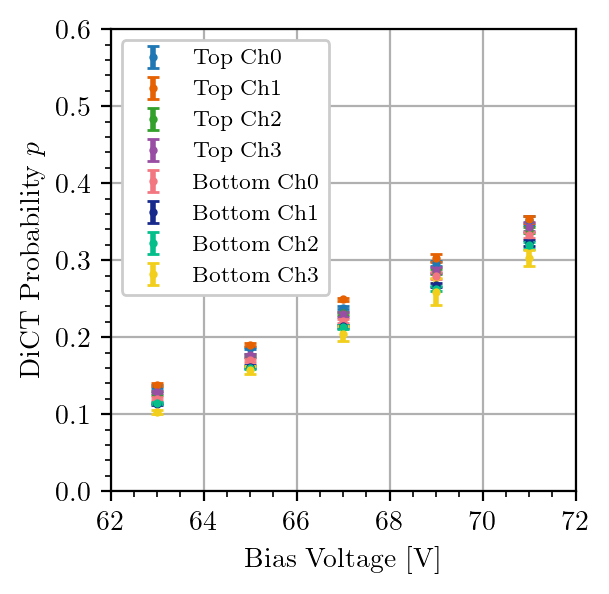

In [16]:
plt.figure(0,figsize=(3,3))
for ch in range(4):
    plt.errorbar(bias, [dset.ch[ch].ct[0] for dset in ds1122top], yerr=[dset.ch[ch].ct[1] for dset in ds1122top], label='Top Ch{}'.format(ch), fmt='o', markersize=2)
for ch in range(4):
    plt.errorbar(bias, [dset.ch[ch].ct[0] for dset in ds1122bot], yerr=[dset.ch[ch].ct[1] for dset in ds1122bot], label='Bottom Ch{}'.format(ch), fmt='o', markersize=2)
plt.legend()
plt.xlabel('Bias Voltage [V]')
plt.ylabel(r'DiCT Probability $p$')
plt.grid()
plt.minorticks_on()
plt.xlim(62,72)
plt.ylim(0, 0.6)

# AP Summary

(0.0, 0.1)

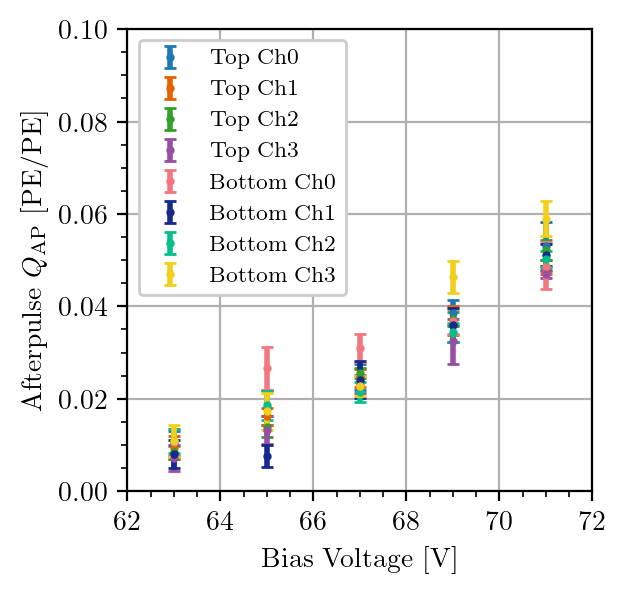

In [17]:
plt.figure(0,figsize=(3,3))
for ch in range(4):
    plt.errorbar(bias, [dset.ch[ch].ap[0] for dset in ds1122top], yerr=[dset.ch[ch].ap[1] for dset in ds1122top], label='Top Ch{}'.format(ch), fmt='o', markersize=2)
for ch in range(4):
    plt.errorbar(bias, [dset.ch[ch].ap[0] for dset in ds1122bot], yerr=[dset.ch[ch].ap[1] for dset in ds1122bot], label='Bottom Ch{}'.format(ch), fmt='o', markersize=2)
plt.legend()
plt.xlabel('Bias Voltage [V]')
plt.ylabel(r'Afterpulse $Q_{\rm AP}$ [PE/PE]')
plt.grid()
plt.minorticks_on()
plt.xlim(62,72)
plt.ylim(0, 0.1)

## Breakdown Voltage Summary

Channel 0 Vbd=54.168+/-0.139V slope=50.446+/-0.609
Channel 1 Vbd=53.186+/-0.136V slope=46.289+/-0.487
Channel 2 Vbd=53.518+/-0.215V slope=46.551+/-0.725
Channel 3 Vbd=53.103+/-0.443V slope=44.407+/-1.268
Channel 0 Vbd=54.450+/-0.240V slope=51.725+/-1.060
Channel 1 Vbd=53.388+/-0.334V slope=43.533+/-1.135
Channel 2 Vbd=53.551+/-0.285V slope=46.822+/-0.929
Channel 3 Vbd=53.397+/-0.451V slope=46.800+/-1.579


/tmp/ipykernel_3035341/700249149.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', '', 'T0', 'T1','T2','T3','B0','B1','B2','B3'])


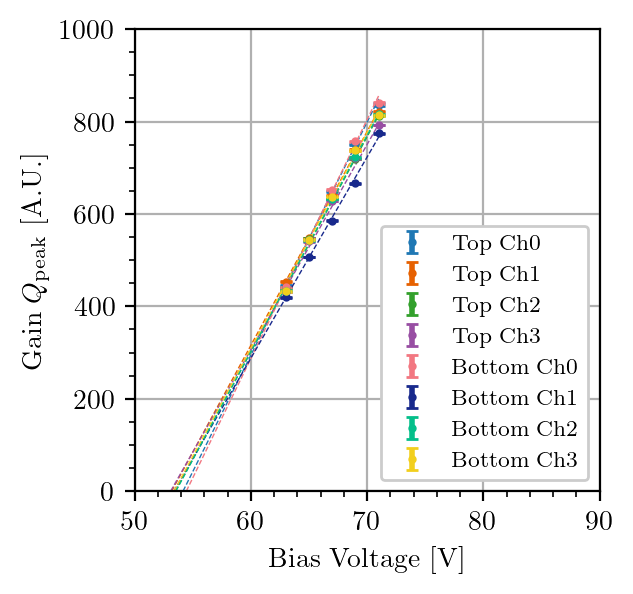

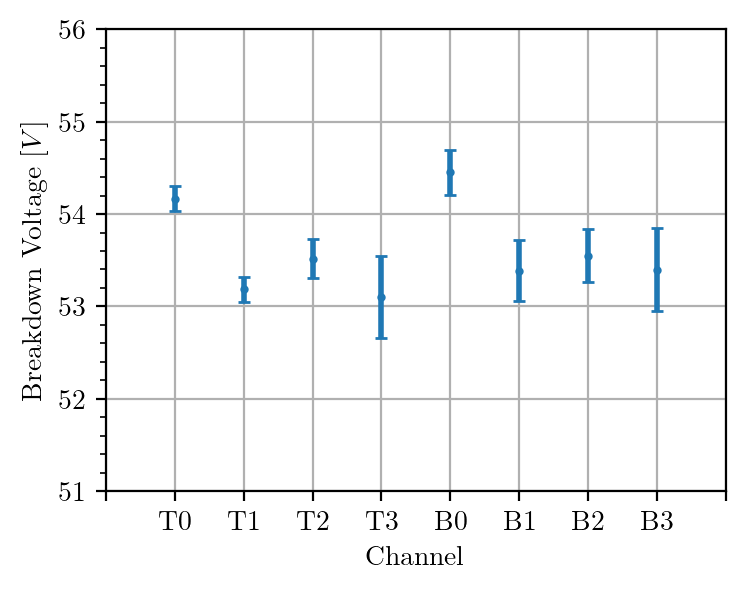

In [57]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

plt.figure(0,figsize=(3,3))
for ch in range(4):
    xlin = bias
    ylin = [data.ch[ch].q_peak[0] for data in ds1122top]
    err = [data.ch[ch].q_peak[1] for data in ds1122top]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, sigma=err, p0=[100, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    plt.errorbar(xlin, ylin, yerr=err, label='Top Ch{}'.format(ch), fmt='C{}o'.format(ch), markersize=2)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'C{}--'.format(ch), linewidth=0.5)

for ch in range(4):
    xlin = bias
    ylin = [data.ch[ch].q_peak[0] for data in ds1122bot]
    err = [data.ch[ch].q_peak[1] for data in ds1122bot]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, sigma=err, p0=[100, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    plt.errorbar(xlin, ylin, yerr=err, label='Bottom Ch{}'.format(ch), fmt='C{}o'.format(ch+4), markersize=2)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'C{}--'.format(ch+4), linewidth=0.5)

plt.legend(loc='lower right')
plt.xlabel('Bias Voltage [V]')
plt.ylabel(r'Gain $Q_{\rm peak}$ [A.U.]')
plt.grid()
plt.minorticks_on()
plt.xlim(50,90)
plt.ylim(0, 1.0e3)

fig, ax = plt.subplots()
vbd_ch = np.concatenate((Vbd_charge_top, Vbd_charge_bot))
plt.errorbar(np.arange(8), vbd_ch[:,0], yerr=vbd_ch[:,1], fmt='o', markersize=2)
plt.xlabel('Channel')
plt.ylabel(r'Breakdown Voltage [$V$]')
ax.set_xticklabels(['', '', 'T0', 'T1','T2','T3','B0','B1','B2','B3'])
plt.xlim(-1,8)
plt.ylim(51,56)
plt.grid()
plt.minorticks_on()
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_tick_params(which='minor', bottom=False)
plt.show()

## Write to csv file

In [15]:
import csv
for i,v in enumerate(bias):
    with open('calibration_1122_{}V.csv'.format(v), 'w') as f:
        w = csv.writer(f)
        w.writerow(['CH', 'A1min', 'A1max', 'p', 'p_err', 'Qavg', 'Qavg_err', 'Qpeak', 'Qpeak_err', 'Qap', 'Qap_err'])
        for ch in range(4):
            dset = ds1122top[i].ch[ch]
            row = ['T{}'.format(ch)]
            row += [str(0.5*dset.famp_hist_fit[0][1][0]), str(0.5*(dset.famp_hist_fit[0][1][0]+dset.famp_hist_fit[1][1][0]))]
            row += [str(dset.ct[0]), str(dset.ct[1])]
            row += [str(dset.q_avg[0]), str(dset.q_avg[1])]
            row += [str(dset.q_peak[0]), str(dset.q_peak[1])]
            row += [str(dset.ap[0]), str(dset.ap[1])]
            w.writerow(row)
        for ch in range(4):
            dset = ds1122bot[i].ch[ch]
            row = ['B{}'.format(ch)]
            row += [str(0.5*dset.famp_hist_fit[0][1][0]), str(0.5*(dset.famp_hist_fit[0][1][0]+dset.famp_hist_fit[1][1][0]))]
            row += [str(dset.ct[0]), str(dset.ct[1])]
            row += [str(dset.q_avg[0]), str(dset.q_avg[1])]
            row += [str(dset.q_peak[0]), str(dset.q_peak[1])]
            row += [str(dset.ap[0]), str(dset.ap[1])]
            w.writerow(row)

## SPE average waveform
Take waveforms with prompt filtered amplitude $|A-A_k|<2\sigma_k$ for $k=1$ and take average.<br>
At $k=1$ PE, afterpulses can be ignored.<br>
The average waveform is fitted by
$$h(t,t') = A_1 e^{-(t-t')/\tau_1} + A_2 e^{-(t-t')/\tau2}$$

# Try to include time jitter
SiPM pulse (single component):
$$h(t,t') = A e^{-\frac{t-t'}{\tau}} \Theta(t-t')$$
Time jitter:
$$g(t') = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(t'-t_0)^2}{2\sigma^2}}$$
Average waveform:
$$
f(t,t') = \int g(t') h(t,t') \, dt'
= \frac{A}{\sigma\sqrt{2\pi}} \int_{-\infty}^{t} e^{-\frac{(t'-t_0)^2}{2\sigma^2}-\frac{t-t'}{\tau}} \, dt'$$

$$ = \frac{A}{\sigma\sqrt{2\pi}} \int_{-\infty}^{t} e^{-\frac{1}{2\sigma^2}[t^{'2} - 2t'(t_0 + \sigma^2/\tau) + t_0^2 + 2\sigma^2 t_0/\tau + \sigma^4 /\tau^2 + 2\sigma^2 (t-t_0)/\tau - \sigma^4/\tau^2]} \, dt'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{\sigma\sqrt{2\pi}} e^{-\frac{t-t_0}{\tau}} \int_{-\infty}^{t} e^{-\frac{1}{2\sigma^2}[t'-(t_0 + \sigma^2/\tau)]^2} \, dt'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{\sqrt{\pi}} e^{-\frac{t-t_0}{\tau}} \int_{-\infty}^{t/\sigma\sqrt{2}} e^{-[x'-\frac{t_0 + \sigma^2/\tau}{\sigma\sqrt{2}}]^2} \, dx'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{2} e^{-\frac{t-t_0}{\tau}} \left[1 + erf\left(\frac{t-t_0-\sigma^2/\tau}{\sigma\sqrt{2}}\right)\right]
$$

## Top

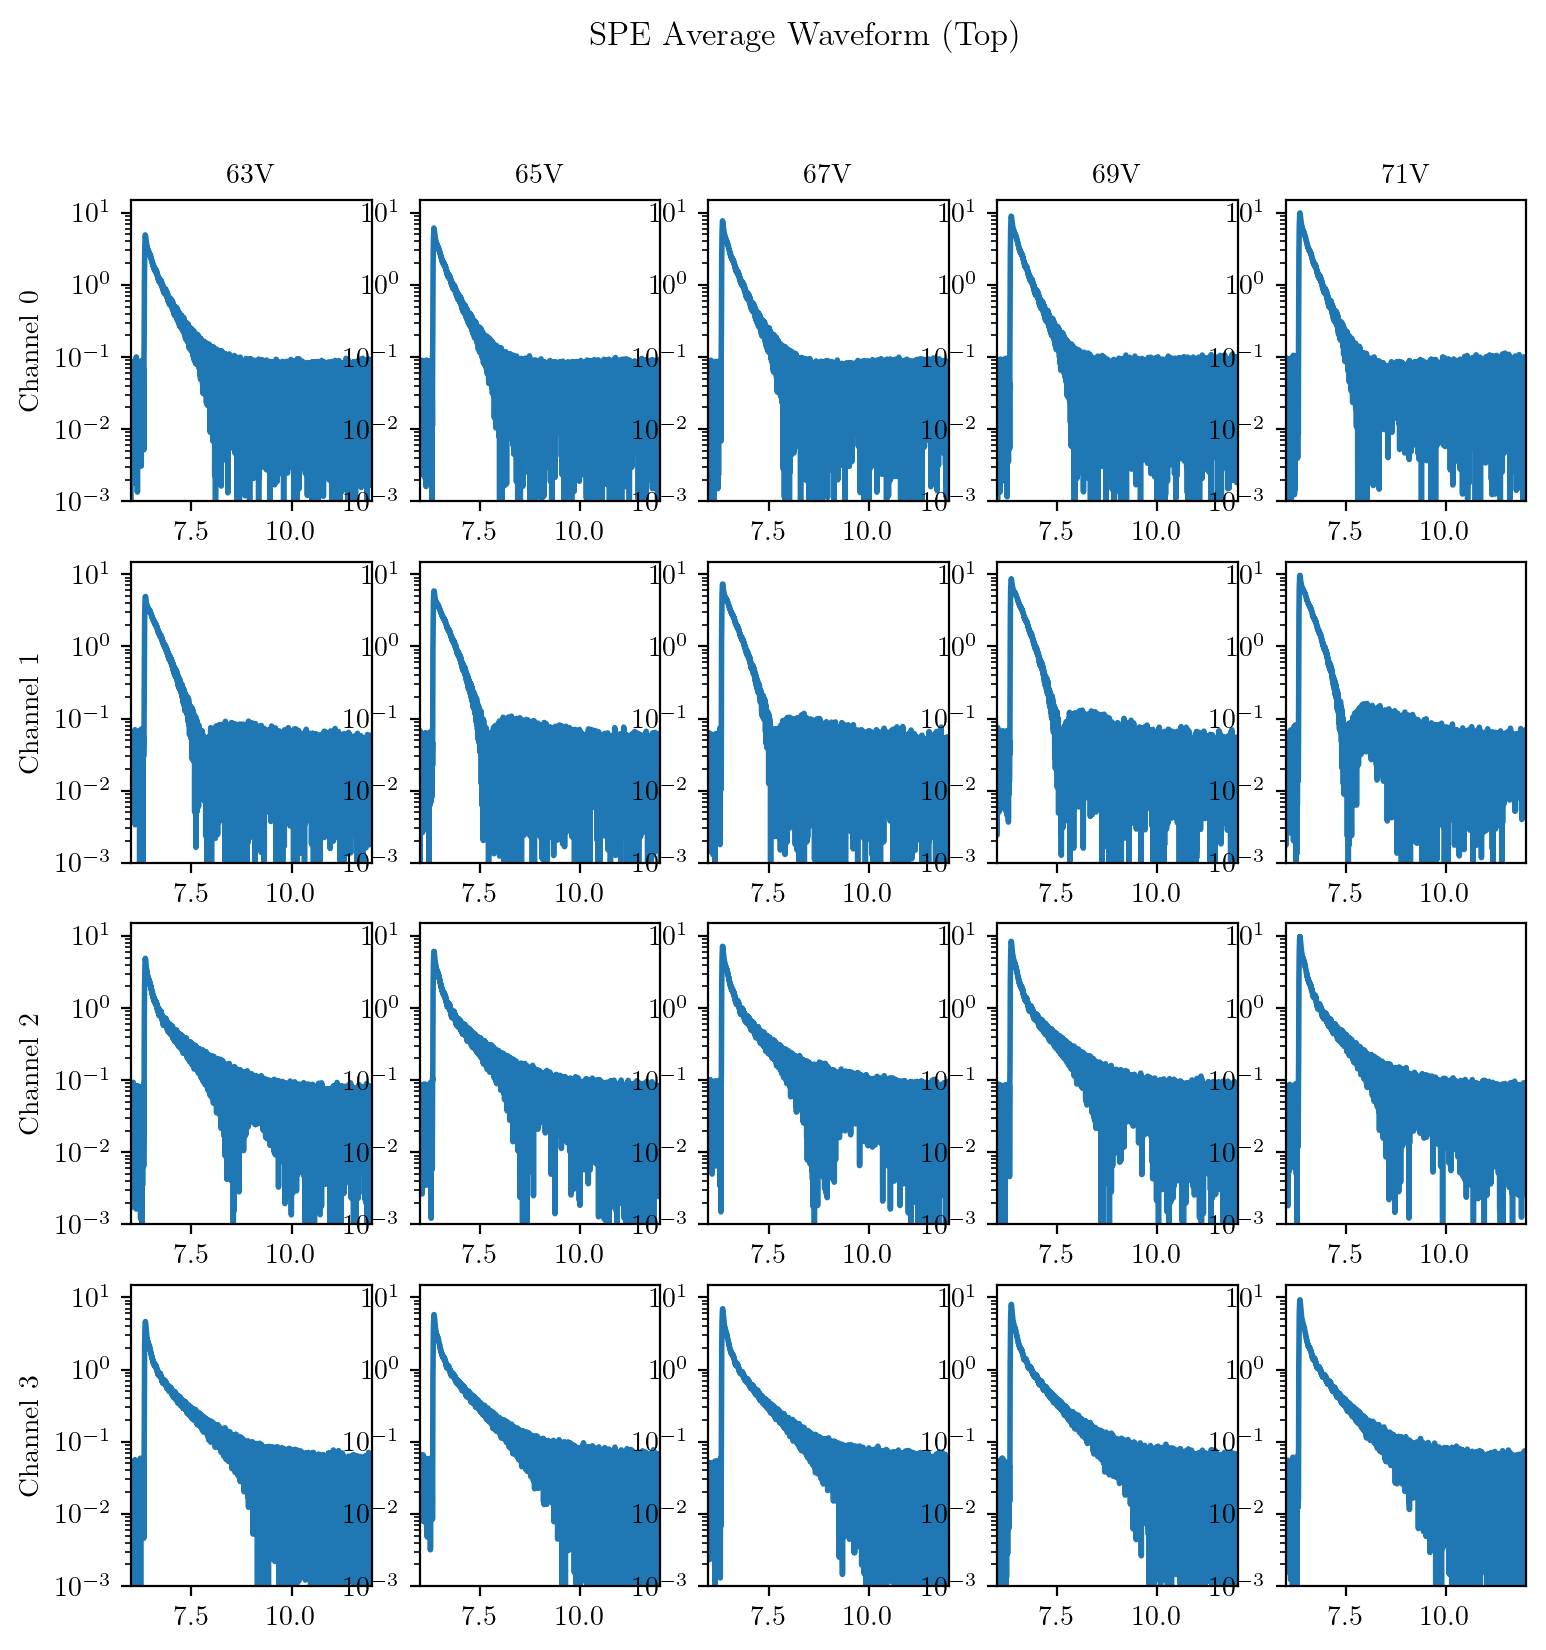

In [16]:
#for spe average waveforms
plt.figure(0,figsize=(9,9))
for i,v in enumerate(bias):
    file = ROOT.TFile('root/SPE_waveform_1122_{}V_top.root'.format(v),'read')
    for ch in range(4):
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        gSPE = file.Get('gSPE_ch{}'.format(ch))
        plt.plot(list(gSPE.GetX()), abs(np.array(list(gSPE.GetY()))))
        # err = np.std(data.ch[ch].spe_avgwf[:data.ch[ch].baseline_samples])
        # t_start = int(data.ch[ch].trigger_position - 0.1/data.ch[ch].sample_step)
        # t_end = int(data.ch[ch].trigger_position + 5/data.ch[ch].sample_step)
        # popt,pcov = curve_fit(data.ch[ch].get_pulse_shape, data.ch[ch].time[t_start:t_end], data.ch[ch].spe_avgwf[t_start:t_end], p0=[4.8,0.25,4.0,0.02,0.008,6.33], sigma=[err]*len(data.ch[ch].time[t_start:t_end]), maxfev=10000)
        # plt.plot(data.ch[ch].time[t_start:t_end], data.ch[ch].get_pulse_shape(data.ch[ch].time[t_start:t_end],*popt))
        # print('CH{} {}V  A1={:.3f}+/-{:.3f} TAU1={:.4f}+/-{:.4f}us A2={:.3f}+/-{:.3f} TAU2={:.4f}+/-{:.4f}us sigma={:.4f}+/-{:.4f}us t0={:.3f}+/-{:.3f}us'.format(ch,bias[i],popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))
        # data.ch[ch].set_pulse_pars(a1=popt[0], tau1=popt[1], a2=popt[2], tau2=popt[3])
        # plt.xlim((t_start-100)*data.ch[ch].sample_step,(t_end+100)*data.ch[ch].sample_step)
        plt.xlim(6,12)
        plt.ylim(1e-3, 15)
        plt.yscale('log')
plt.suptitle('SPE Average Waveform (Top)')
plt.savefig('plots/sipm/spewf_top_1122.pdf')

## Bottom

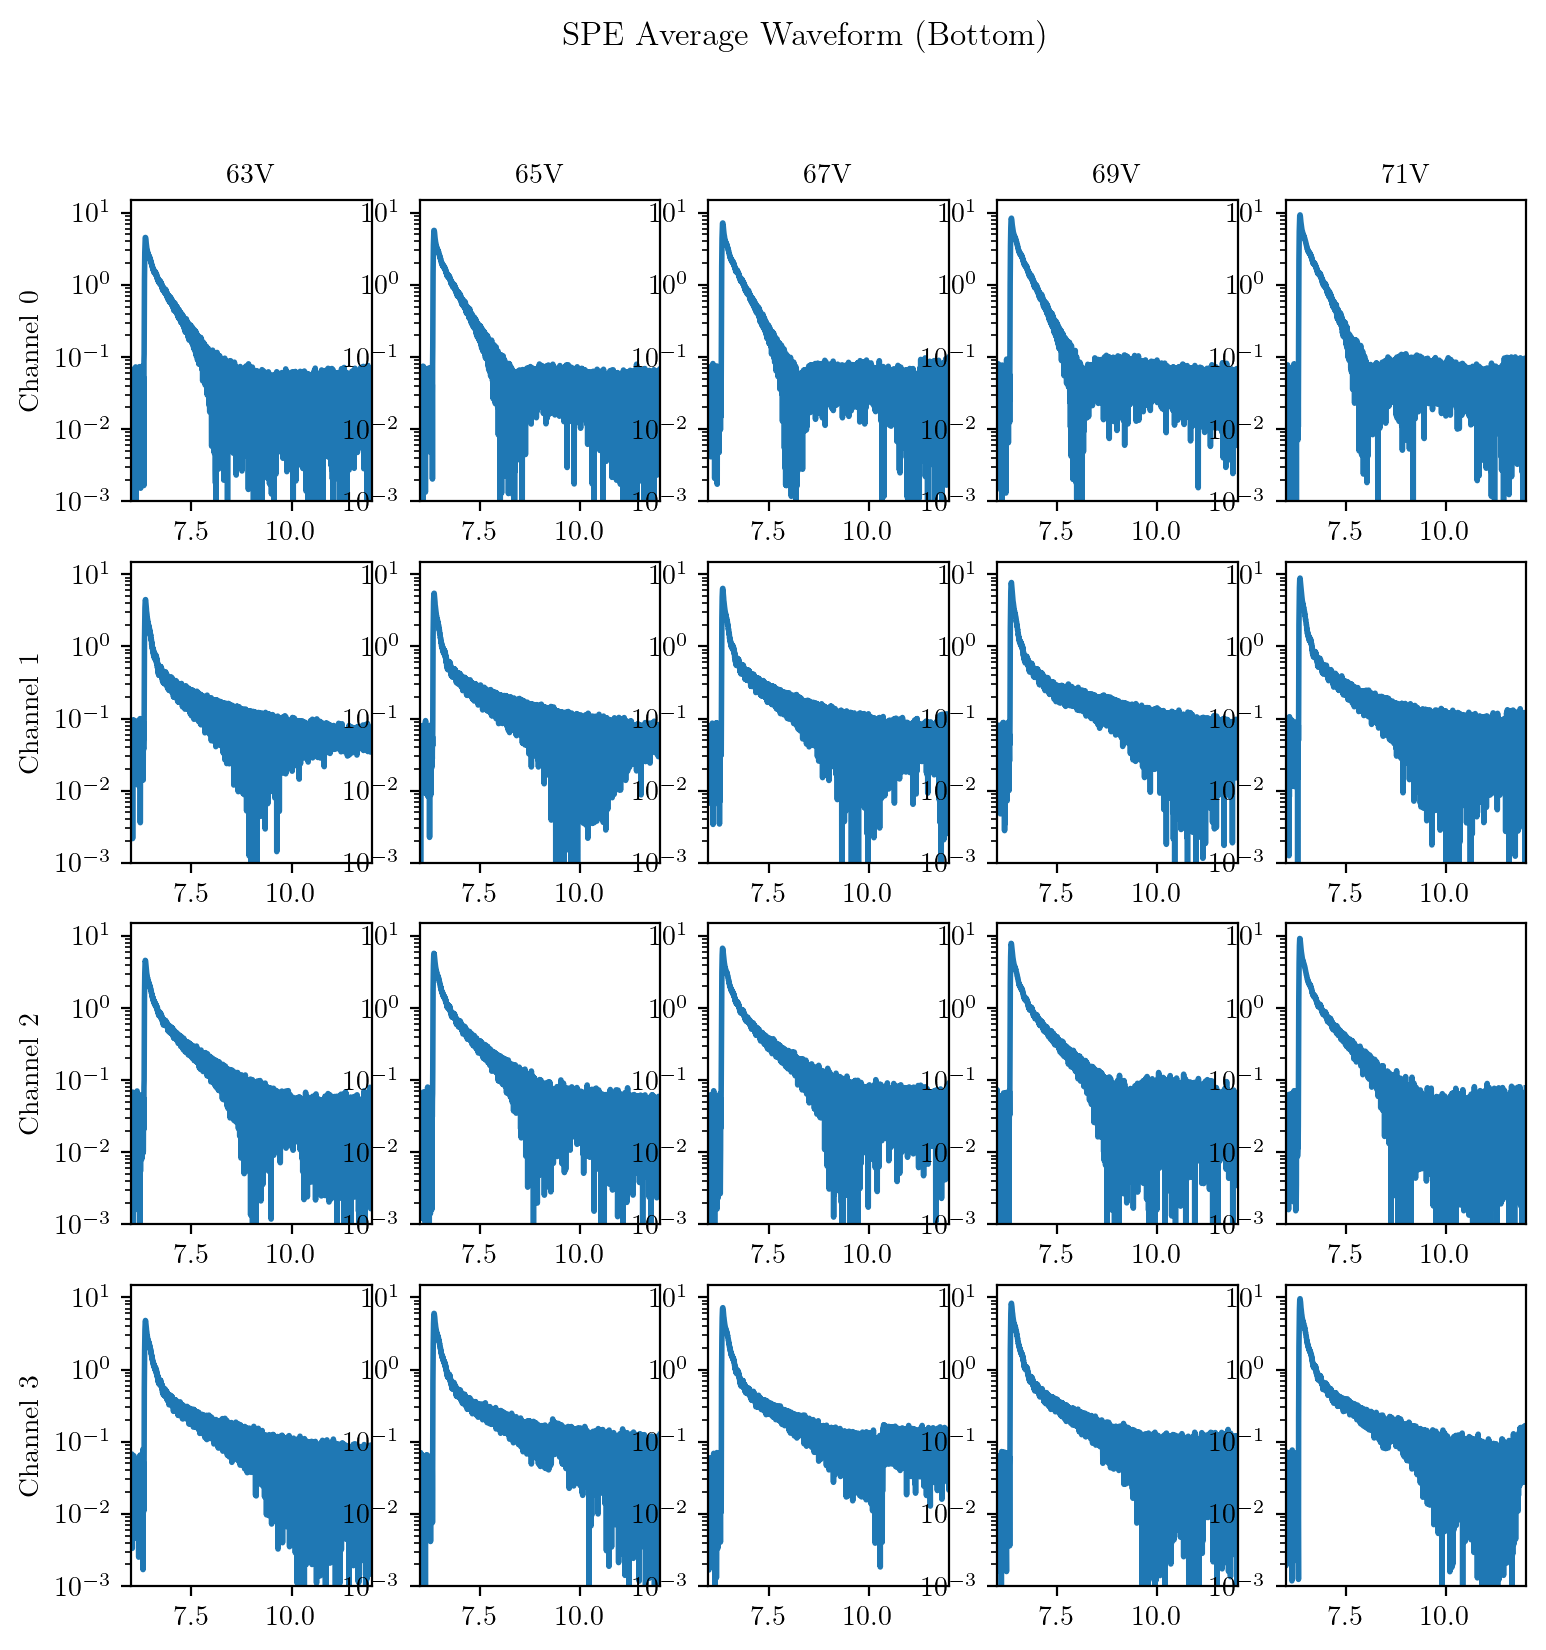

In [17]:
#for spe average waveforms
plt.figure(0,figsize=(9,9))
for i,v in enumerate(bias):
    file = ROOT.TFile('root/SPE_waveform_1122_{}V_bottom.root'.format(v),'read')
    for ch in range(4):
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        gSPE = file.Get('gSPE_ch{}'.format(ch))
        plt.plot(list(gSPE.GetX()), abs(np.array(list(gSPE.GetY()))))
        # err = np.std(data.ch[ch].spe_avgwf[:data.ch[ch].baseline_samples])
        # t_start = int(data.ch[ch].trigger_position - 0.1/data.ch[ch].sample_step)
        # t_end = int(data.ch[ch].trigger_position + 5/data.ch[ch].sample_step)
        # popt,pcov = curve_fit(data.ch[ch].get_pulse_shape, data.ch[ch].time[t_start:t_end], data.ch[ch].spe_avgwf[t_start:t_end], p0=[5,1,6,0.1,0.005,6.45,6.30], sigma=[err]*len(data.ch[ch].time[t_start:t_end]), maxfev=10000)
        # plt.plot(data.ch[ch].time[t_start:t_end], data.ch[ch].get_pulse_shape(data.ch[ch].time[t_start:t_end],*popt))
        # print('CH{} {}V  A1={:.3f}+/-{:.3f} TAU1={:.4f}+/-{:.4f}us A2={:.3f}+/-{:.3f} TAU2={:.4f}+/-{:.4f}us sigma={:.4f}+/-{:.4f}us t1={:.3f}+/-{:.3f}us, t2={:.3f}+/-{:.3f}us'.format(ch,bias[i],popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5]),popt[6],np.sqrt(pcov[6,6])))
        # data.ch[ch].set_pulse_pars(a1=popt[0], tau1=popt[1], a2=popt[2], tau2=popt[3])
        # plt.xlim((t_start-100)*data.ch[ch].sample_step,(t_end+100)*data.ch[ch].sample_step)
        plt.xlim(6,12)
        plt.ylim(1e-3, 15)
        plt.yscale('log')
plt.suptitle('SPE Average Waveform (Bottom)')
plt.savefig('plots/sipm/spewf_bot_1122.pdf')

## Take closer look at one channel one voltage

/home/as111/.conda/envs/ds-pu/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/as111/.conda/envs/ds-pu/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/as111/.conda/envs/ds-pu/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/as111/.conda/envs/ds-pu/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/as111/.conda/envs/ds-pu/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan
0.0 nan nan
nan nan


TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

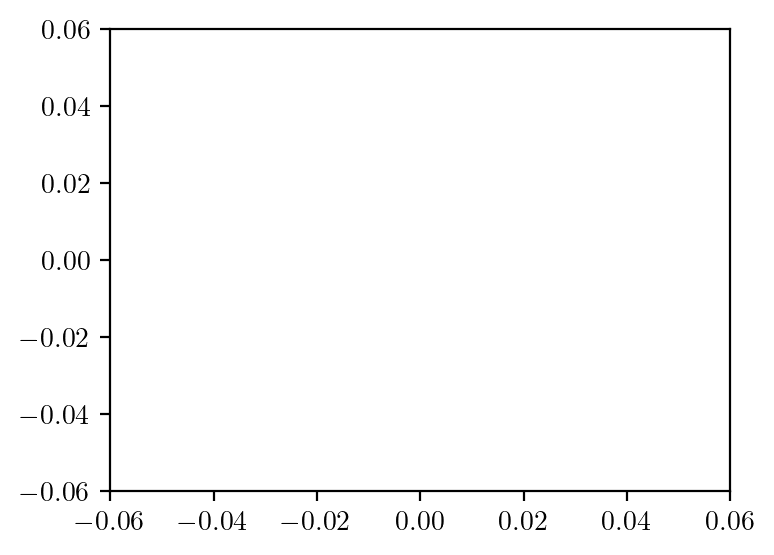

In [18]:
ch=0
i=2
dset = ds1122top[i].ch[ch]

plt.plot(dset.time, dset.spe_avgwf, label='Data', linewidth=1)
print(np.std(dset.spe_avgwf[:dset.baseline_samples]))
print(dset.baseline_samples*dset.sample_step, np.mean(dset.spe_avgwf[:dset.baseline_samples]), np.median(dset.spe_avgwf[:dset.baseline_samples]))
print(np.mean(dset.spe_avgwf[int(12/dset.sample_step):]), np.median(dset.spe_avgwf[int(12/dset.sample_step):]))
plt.plot(dset.time, dset.get_pulse_shape(dset.time, dset.get_pulse_pars()[0], dset.get_pulse_pars()[1], dset.get_pulse_pars()[2], dset.get_pulse_pars()[3],0.0074,6.327), label='Fit', linewidth=1)
# plt.xlim((t_start-100)*data.ch[ch].sample_step,(t_end+100)*data.ch[ch].sample_step)
plt.ylim(-1, 1)
plt.xlim(0,16)
plt.legend(loc='upper right')
# plt.yscale('log')
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel(r'Voltage [ADC Count]')
plt.suptitle('SPE Average Waveform (Top Ch{} {}V)'.format(ch.bias[i]))


# Try FFT-based deconvolution
- $\tilde{f}(\omega)$: average waveform FFT
- $\tilde{g}(\omega)$: start time distribution FFT
- $\tilde{h}(\omega)$: SiPM pulse FFT
$$\tilde{g}(\omega) \propto \frac{\tilde{f}(\omega)}{\tilde{h}(\omega)}$$

In [ ]:
from scipy.fft import fft, ifft
dset = datasets_bot[2].ch[0]
ftilde = fft(dset.spe_avgwf)
a1,tau1,a2,tau2 = dset.get_pulse_pars()
h = lambda x: a1*np.exp(-x/tau1)+a2*np.exp(-x/tau2)
htilde = fft(h(dset.time))

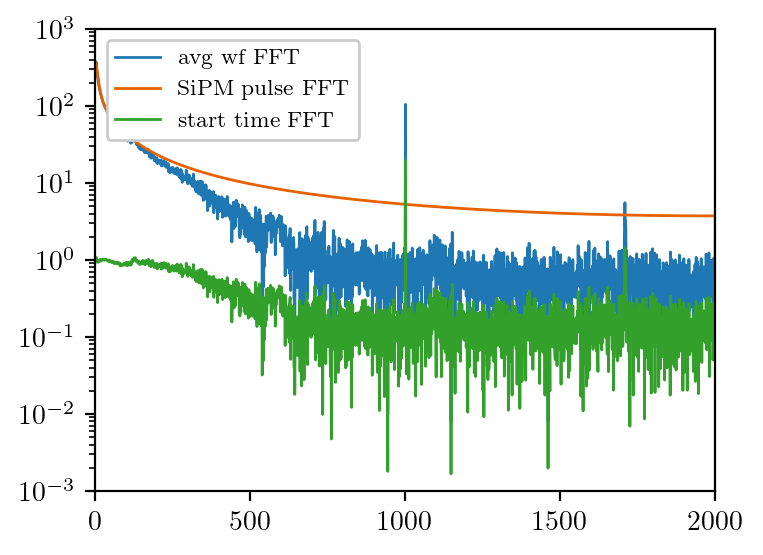

In [ ]:
plt.plot(abs(ftilde), label='avg wf FFT', linewidth=1)
plt.plot(abs(htilde), label='SiPM pulse FFT', linewidth=1)
plt.plot(abs(ftilde/htilde), label='start time FFT', linewidth=1)
plt.legend()
plt.xlim(0,2000)
plt.yscale('log')

/home/as111/.conda/envs/ds-pu/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.9400054783777446


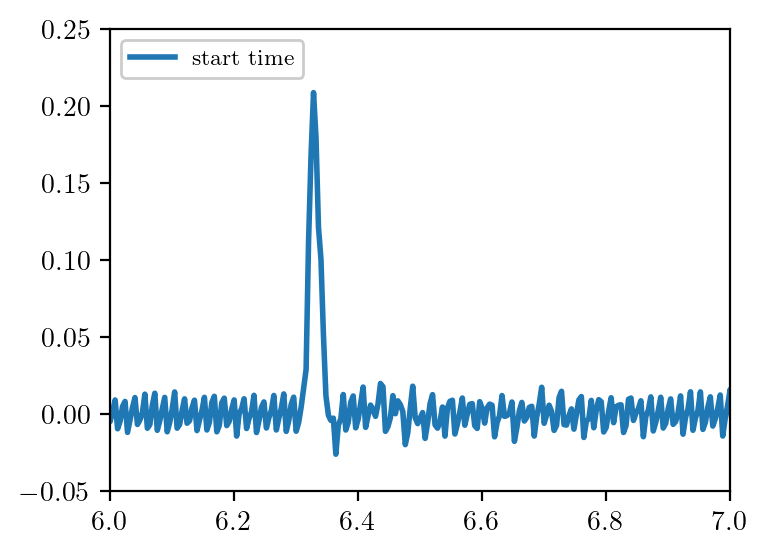

In [ ]:
plt.plot(dset.time, ifft(ftilde/htilde), label='start time')
plt.legend()
plt.xlim(6,7)
print(abs(np.sum((ifft(ftilde/htilde)))))